In [1]:
!nvidia-smi

Sat Mar  2 14:47:55 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:2D:00.0  On |                  N/A |
|  0%   48C    P8    18W / 170W |    330MiB / 12288MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.getcwd()

'/home/bunny/projects/IConNet/notebooks'

In [4]:
os.chdir('..')

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [11]:
data_dir = '../data/crema_d/preprocessing/'

In [15]:
sr = 16000

data_x = np.load(f'{data_dir}crema_d.audio16k.npy', allow_pickle=True)
data_y = np.load(f'{data_dir}crema_d.label6.npy', allow_pickle=True)
# classnames = np.load(f'{data_dir}crema_d.classnames.npy', allow_pickle=True)
print(data_x.shape)
print(data_y.shape)
np.unique(data_y)

(7442,)
(7442,)


array(['ang', 'dis', 'fea', 'hap', 'neu', 'sad'], dtype=object)

In [16]:
labels = ['ang', 'neu', 'sad', 'hap']

def label_filter(label):
    return label[:3] in labels

def label_to_index(label):
    return labels.index(label[:3])
    
filtered_idx = [label_filter(idx) for idx in data_y]
data_x = data_x[filtered_idx]
data_y = [label_to_index(idx) for idx in data_y[filtered_idx]]
print(data_x.shape)

(4900,)


In [17]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, 
    random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 3920
Test: 980


In [18]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [19]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.).permute(0, 2, 1)
    return batch

def collate_fn(batch, max_duration_in_second=3, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            waveform = np.array(waveform, dtype=float).squeeze()
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = waveform[offset: length-offset]
        tensors += [torch.tensor(waveform, dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label, dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [20]:
from IConNet.nn.model import M13sinc as M13

In [21]:
from omegaconf import OmegaConf as ocf

In [22]:
import traceback

In [23]:
model_config_path = 'config/model/m14sinc.yaml'
model_config = ocf.load(model_config_path)
model_config

{'name': 'M14sinc', 'description': 'FirConv with fftconv', 'fe': {'n_block': 2, 'n_channel': [198, 30], 'kernel_size': [511, 127], 'stride': [2, 4], 'window_k': [5, 9], 'residual_connection_type': 'stack', 'pooling': 'mean', 'filter_type': 'sinc', 'learnable_bands': True, 'learnable_windows': False, 'shared_window': True, 'window_func': 'hamming', 'mel_resolution': 3, 'conv_mode': 'fftconv', 'norm_type': 'LocalResponseNorm'}, 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}

In [24]:
model = M13(config=model_config,
           n_input=1, n_output=len(labels))
model

M13sinc(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x FrontEndBlock(
        (block): ModuleDict(
          (layer): FirConvLayer(
            (conv_layer): ResidualConv1d(
              (pad_layer): PadForConv()
              (stride_layer): DownsampleLayer(
                (pad_right): PadForConv()
              )
              (norm_layer): CustomNormLayer(
                (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
              )
              (act): NLReLU()
            )
          )
          (downsample): ResidualConv1d(
            (pad_layer): PadForConv()
            (stride_layer): DownsampleLayer(
              (pad_right): PadForConv()
            )
            (norm_layer): CustomNormLayer(
              (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
            )
            (act): NLReLU()
          )
        )
      )
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (no

In [25]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [26]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch, test_loader=test_loader, device=device):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [27]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                   | 0.0032679738562091504/10 [00:01<1:23:23, 500.52s/it]

Train Epoch: 1 [0/3920 (0%)]	Loss: 1.433397
Mem before-during-after: 1692160 3958231040 26915328


  1%|▉                                                                       | 0.1339869281045752/10 [00:16<21:04, 128.19s/it]

Train Epoch: 1 [640/3920 (16%)]	Loss: 1.439748
Mem before-during-after: 26915328 3971436544 27239936


  3%|█▉                                                                     | 0.26470588235294074/10 [00:32<21:58, 135.42s/it]

Train Epoch: 1 [1280/3920 (33%)]	Loss: 1.218514
Mem before-during-after: 27239936 3911151616 26915328


  4%|██▊                                                                     | 0.3954248366013063/10 [00:47<20:43, 129.44s/it]

Train Epoch: 1 [1920/3920 (49%)]	Loss: 1.259138
Mem before-during-after: 27239936 3970849792 26915328


  5%|███▊                                                                    | 0.5261437908496719/10 [01:02<20:11, 127.85s/it]

Train Epoch: 1 [2560/3920 (65%)]	Loss: 1.726061
Mem before-during-after: 26915328 3971174400 26915328


  7%|████▋                                                                   | 0.6568627450980374/10 [01:17<19:49, 127.27s/it]

Train Epoch: 1 [3200/3920 (82%)]	Loss: 0.943665
Mem before-during-after: 27796992 3971731456 27040256


  8%|█████▋                                                                   | 0.787581699346403/10 [01:32<19:55, 129.80s/it]

Train Epoch: 1 [3840/3920 (98%)]	Loss: 1.093386
Mem before-during-after: 26915328 3971499008 27040256


 10%|███████▍                                                                  | 0.999999999999997/10 [01:47<10:59, 73.31s/it]


Test Epoch: 1	Accuracy: 558/976 (57%)



 10%|███████▎                                                                 | 1.0032679738562063/10 [01:47<12:40, 84.58s/it]

Train Epoch: 2 [0/3920 (0%)]	Loss: 1.637170
Mem before-during-after: 26914304 3768206336 26915328


 11%|████████▏                                                               | 1.1339869281045718/10 [02:02<18:58, 128.41s/it]

Train Epoch: 2 [640/3920 (16%)]	Loss: 1.025200
Mem before-during-after: 26915328 3971374080 26915328


 13%|█████████                                                               | 1.2647058823529373/10 [02:17<18:41, 128.39s/it]

Train Epoch: 2 [1280/3920 (33%)]	Loss: 1.286568
Mem before-during-after: 27239936 3971174400 27040256


 14%|██████████▏                                                              | 1.395424836601303/10 [02:32<18:19, 127.75s/it]

Train Epoch: 2 [1920/3920 (49%)]	Loss: 0.960031
Mem before-during-after: 26915328 3971731456 27040256


 15%|██████████▉                                                             | 1.5261437908496684/10 [02:47<18:14, 129.17s/it]

Train Epoch: 2 [2560/3920 (65%)]	Loss: 0.876042
Mem before-during-after: 26915328 3971499008 27040256


 17%|████████████                                                             | 1.656862745098034/10 [03:02<17:50, 128.27s/it]

Train Epoch: 2 [3200/3920 (82%)]	Loss: 0.617260
Mem before-during-after: 26915328 3971931136 27796992


 18%|████████████▊                                                           | 1.7875816993463995/10 [03:17<17:29, 127.84s/it]

Train Epoch: 2 [3840/3920 (98%)]	Loss: 1.060453
Mem before-during-after: 27040256 3971823616 27040256


 20%|██████████████▌                                                          | 1.9999999999999936/10 [03:32<08:47, 65.96s/it]


Test Epoch: 2	Accuracy: 594/976 (61%)



 20%|██████████████▊                                                           | 2.003267973856203/10 [03:32<10:43, 80.52s/it]

Train Epoch: 3 [0/3920 (0%)]	Loss: 0.816095
Mem before-during-after: 26914304 3971510784 26915328


 21%|███████████████▎                                                        | 2.1339869281045685/10 [03:47<16:52, 128.77s/it]

Train Epoch: 3 [640/3920 (16%)]	Loss: 1.164136
Mem before-during-after: 26915328 3971049472 26915328


 23%|████████████████▌                                                        | 2.264705882352934/10 [04:02<16:33, 128.43s/it]

Train Epoch: 3 [1280/3920 (33%)]	Loss: 1.165398
Mem before-during-after: 26915328 3971174400 26915328


 24%|█████████████████▏                                                      | 2.3954248366012996/10 [04:17<16:28, 129.94s/it]

Train Epoch: 3 [1920/3920 (49%)]	Loss: 1.045943
Mem before-during-after: 26915328 3973041152 26915328


 25%|██████████████████▍                                                      | 2.526143790849665/10 [04:32<15:54, 127.72s/it]

Train Epoch: 3 [2560/3920 (65%)]	Loss: 0.892213
Mem before-during-after: 26915328 3971049472 26915328


 27%|███████████████████▏                                                    | 2.6568627450980307/10 [04:47<15:36, 127.53s/it]

Train Epoch: 3 [3200/3920 (82%)]	Loss: 0.960363
Mem before-during-after: 27239936 3971731456 27040256


 28%|████████████████████▎                                                    | 2.787581699346396/10 [05:02<15:21, 127.82s/it]

Train Epoch: 3 [3840/3920 (98%)]	Loss: 0.836234
Mem before-during-after: 27040256 3972380672 27040256


 30%|█████████████████████▉                                                   | 2.9999999999999902/10 [05:17<07:35, 65.07s/it]


Test Epoch: 3	Accuracy: 573/976 (58%)



 30%|█████████████████████▉                                                   | 3.0032679738561994/10 [05:17<09:18, 79.89s/it]

Train Epoch: 4 [0/3920 (0%)]	Loss: 0.914828
Mem before-during-after: 26914304 3971510784 26915328


 31%|██████████████████████▉                                                  | 3.133986928104565/10 [05:32<14:27, 126.29s/it]

Train Epoch: 4 [640/3920 (16%)]	Loss: 0.711502
Mem before-during-after: 26915328 3911774208 26915328


 33%|███████████████████████▌                                                | 3.2647058823529305/10 [05:47<14:09, 126.11s/it]

Train Epoch: 4 [1280/3920 (33%)]	Loss: 0.906681
Mem before-during-after: 27040256 3970767360 26915328


 34%|████████████████████████▊                                                | 3.395424836601296/10 [06:02<13:53, 126.21s/it]

Train Epoch: 4 [1920/3920 (49%)]	Loss: 0.952309
Mem before-during-after: 26915328 3972488192 27796992


 35%|█████████████████████████▍                                              | 3.5261437908496616/10 [06:17<13:41, 126.82s/it]

Train Epoch: 4 [2560/3920 (65%)]	Loss: 0.777249
Mem before-during-after: 26915328 3549542400 26915328


 37%|██████████████████████████▋                                              | 3.656862745098027/10 [06:31<13:30, 127.72s/it]

Train Epoch: 4 [3200/3920 (82%)]	Loss: 0.960348
Mem before-during-after: 26915328 3972327424 26915328


 38%|███████████████████████████▎                                            | 3.7875816993463927/10 [06:46<13:08, 126.93s/it]

Train Epoch: 4 [3840/3920 (98%)]	Loss: 0.981801
Mem before-during-after: 26915328 3972308480 26915328


 40%|█████████████████████████████▏                                           | 3.9999999999999867/10 [07:01<06:33, 65.66s/it]


Test Epoch: 4	Accuracy: 570/976 (58%)



 40%|█████████████████████████████▌                                            | 4.003267973856196/10 [07:01<07:59, 80.02s/it]

Train Epoch: 5 [0/3920 (0%)]	Loss: 0.745489
Mem before-during-after: 26914304 3971467264 26915328


 41%|██████████████████████████████▏                                          | 4.133986928104561/10 [07:16<12:35, 128.83s/it]

Train Epoch: 5 [640/3920 (16%)]	Loss: 0.894215
Mem before-during-after: 26915328 3971784704 26915328


 43%|███████████████████████████████▏                                         | 4.264705882352927/10 [07:31<12:17, 128.52s/it]

Train Epoch: 5 [1280/3920 (33%)]	Loss: 1.020393
Mem before-during-after: 26915328 3972714496 26915328


 44%|███████████████████████████████▋                                        | 4.3954248366012925/10 [07:46<11:57, 127.99s/it]

Train Epoch: 5 [1920/3920 (49%)]	Loss: 0.891617
Mem before-during-after: 26915328 3972308480 26915328


 45%|█████████████████████████████████                                        | 4.526143790849658/10 [08:01<11:35, 127.10s/it]

Train Epoch: 5 [2560/3920 (65%)]	Loss: 1.074574
Mem before-during-after: 26915328 3970617344 26915328


 47%|█████████████████████████████████▉                                       | 4.656862745098024/10 [08:16<11:23, 127.89s/it]

Train Epoch: 5 [3200/3920 (82%)]	Loss: 0.846902
Mem before-during-after: 26915328 3972308480 26915328


 48%|██████████████████████████████████▉                                      | 4.787581699346389/10 [08:31<11:05, 127.75s/it]

Train Epoch: 5 [3840/3920 (98%)]	Loss: 0.535159
Mem before-during-after: 26915328 3970617344 26915328


 50%|████████████████████████████████████▉                                     | 4.999999999999983/10 [08:46<05:59, 71.85s/it]


Test Epoch: 5	Accuracy: 513/976 (52%)



 50%|█████████████████████████████████████                                     | 5.003267973856192/10 [08:46<07:02, 84.47s/it]

Train Epoch: 6 [0/3920 (0%)]	Loss: 0.793250
Mem before-during-after: 26914304 3971467264 26915328


 51%|█████████████████████████████████████▍                                   | 5.133986928104558/10 [09:01<10:19, 127.33s/it]

Train Epoch: 6 [640/3920 (16%)]	Loss: 1.206350
Mem before-during-after: 26915328 3972308480 26915328


 53%|██████████████████████████████████████▍                                  | 5.264705882352923/10 [09:16<10:04, 127.57s/it]

Train Epoch: 6 [1280/3920 (33%)]	Loss: 1.350797
Mem before-during-after: 26915328 3972308480 26915328


 54%|███████████████████████████████████████▍                                 | 5.395424836601289/10 [09:31<09:45, 127.22s/it]

Train Epoch: 6 [1920/3920 (49%)]	Loss: 0.704171
Mem before-during-after: 26915328 3972308480 26915328


 55%|███████████████████████████████████████▊                                | 5.5261437908496545/10 [09:46<09:26, 126.64s/it]

Train Epoch: 6 [2560/3920 (65%)]	Loss: 1.280847
Mem before-during-after: 26915328 3972308480 26915328


 57%|█████████████████████████████████████████▊                                | 5.65686274509802/10 [10:01<09:16, 128.16s/it]

Train Epoch: 6 [3200/3920 (82%)]	Loss: 1.005673
Mem before-during-after: 26915328 3971194368 26915328


 58%|█████████████████████████████████████████▋                              | 5.7875816993463856/10 [10:16<08:58, 127.78s/it]

Train Epoch: 6 [3840/3920 (98%)]	Loss: 1.051844
Mem before-during-after: 26915328 3971909632 26915328


 60%|████████████████████████████████████████████▉                              | 5.99999999999998/10 [10:31<04:21, 65.33s/it]


Test Epoch: 6	Accuracy: 600/976 (61%)



 60%|████████████████████████████████████████████▍                             | 6.003267973856189/10 [10:31<05:13, 78.40s/it]

Train Epoch: 7 [0/3920 (0%)]	Loss: 0.955022
Mem before-during-after: 26914304 3642029568 26915328


 61%|████████████████████████████████████████████▊                            | 6.133986928104554/10 [10:46<08:06, 125.88s/it]

Train Epoch: 7 [640/3920 (16%)]	Loss: 0.812511
Mem before-during-after: 26915328 3971499008 27040256


 63%|██████████████████████████████████████████████▎                           | 6.26470588235292/10 [11:01<07:51, 126.10s/it]

Train Epoch: 7 [1280/3920 (33%)]	Loss: 0.762981
Mem before-during-after: 26915328 3970902528 26915328


 64%|██████████████████████████████████████████████▋                          | 6.395424836601285/10 [11:15<07:35, 126.36s/it]

Train Epoch: 7 [1920/3920 (49%)]	Loss: 0.847077
Mem before-during-after: 26915328 3972308480 26915328


 65%|███████████████████████████████████████████████▋                         | 6.526143790849651/10 [11:30<07:23, 127.71s/it]

Train Epoch: 7 [2560/3920 (65%)]	Loss: 0.849253
Mem before-during-after: 26915328 3972308480 26915328


 67%|███████████████████████████████████████████████▉                        | 6.6568627450980165/10 [11:45<07:05, 127.41s/it]

Train Epoch: 7 [3200/3920 (82%)]	Loss: 0.607847
Mem before-during-after: 27040256 3971784192 26915328


 68%|█████████████████████████████████████████████████▌                       | 6.787581699346382/10 [12:00<06:49, 127.49s/it]

Train Epoch: 7 [3840/3920 (98%)]	Loss: 1.038073
Mem before-during-after: 26915328 3972288512 26915328


 70%|███████████████████████████████████████████████████▊                      | 6.999999999999976/10 [12:15<03:16, 65.46s/it]


Test Epoch: 7	Accuracy: 573/976 (58%)



 70%|███████████████████████████████████████████████████▊                      | 7.003267973856185/10 [12:15<03:59, 79.85s/it]

Train Epoch: 8 [0/3920 (0%)]	Loss: 1.068506
Mem before-during-after: 26914304 3971466752 26915328


 71%|████████████████████████████████████████████████████                     | 7.133986928104551/10 [12:30<06:11, 129.67s/it]

Train Epoch: 8 [640/3920 (16%)]	Loss: 0.895831
Mem before-during-after: 26915328 3970617344 26915328


 73%|█████████████████████████████████████████████████████                    | 7.264705882352916/10 [12:45<05:54, 129.56s/it]

Train Epoch: 8 [1280/3920 (33%)]	Loss: 0.746425
Mem before-during-after: 26915328 3972308480 26915328


 74%|█████████████████████████████████████████████████████▉                   | 7.395424836601282/10 [13:00<05:29, 126.42s/it]

Train Epoch: 8 [1920/3920 (49%)]	Loss: 0.907809
Mem before-during-after: 26915328 3972308480 26915328


 75%|██████████████████████████████████████████████████████▉                  | 7.526143790849647/10 [13:15<05:15, 127.70s/it]

Train Epoch: 8 [2560/3920 (65%)]	Loss: 0.572507
Mem before-during-after: 26915328 3970617344 26915328


 77%|███████████████████████████████████████████████████████▉                 | 7.656862745098013/10 [13:30<04:58, 127.52s/it]

Train Epoch: 8 [3200/3920 (82%)]	Loss: 1.248260
Mem before-during-after: 26915328 3805875200 26915328


 78%|████████████████████████████████████████████████████████                | 7.7875816993463784/10 [13:45<04:44, 128.61s/it]

Train Epoch: 8 [3840/3920 (98%)]	Loss: 0.752951
Mem before-during-after: 26915328 3971984384 26915328


 80%|██████████████████████████████████████████████████████████▍              | 7.9999999999999725/10 [14:00<02:17, 68.81s/it]


Test Epoch: 8	Accuracy: 569/976 (58%)



 80%|███████████████████████████████████████████████████████████▏              | 8.003267973856182/10 [14:00<02:45, 82.86s/it]

Train Epoch: 9 [0/3920 (0%)]	Loss: 1.117891
Mem before-during-after: 26914304 3971466752 26915328


 81%|███████████████████████████████████████████████████████████▍             | 8.133986928104548/10 [14:15<03:59, 128.28s/it]

Train Epoch: 9 [640/3920 (16%)]	Loss: 0.957845
Mem before-during-after: 26915328 3970525184 26915328


 83%|████████████████████████████████████████████████████████████▎            | 8.264705882352914/10 [14:30<03:43, 128.81s/it]

Train Epoch: 9 [1280/3920 (33%)]	Loss: 0.909812
Mem before-during-after: 26915328 3972308480 26915328


 84%|██████████████████████████████████████████████████████████████▏           | 8.39542483660128/10 [14:45<03:26, 128.63s/it]

Train Epoch: 9 [1920/3920 (49%)]	Loss: 0.887837
Mem before-during-after: 26915328 3971499520 27040256


 85%|██████████████████████████████████████████████████████████████▏          | 8.526143790849645/10 [15:01<03:10, 129.42s/it]

Train Epoch: 9 [2560/3920 (65%)]	Loss: 0.732880
Mem before-during-after: 26915328 3882674176 26915328


 87%|████████████████████████████████████████████████████████████████          | 8.65686274509801/10 [15:16<02:53, 129.52s/it]

Train Epoch: 9 [3200/3920 (82%)]	Loss: 0.860959
Mem before-during-after: 26915328 3970617344 26915328


 88%|████████████████████████████████████████████████████████████████▏        | 8.787581699346376/10 [15:31<02:36, 128.68s/it]

Train Epoch: 9 [3840/3920 (98%)]	Loss: 1.398564
Mem before-during-after: 26915328 3972308480 26915328


 90%|███████████████████████████████████████████████████████████████████▍       | 8.99999999999997/10 [15:46<01:06, 66.32s/it]


Test Epoch: 9	Accuracy: 540/976 (55%)



 90%|██████████████████████████████████████████████████████████████████▌       | 9.003267973856179/10 [15:46<01:21, 81.52s/it]

Train Epoch: 10 [0/3920 (0%)]	Loss: 0.832907
Mem before-during-after: 26914304 3971467264 26915328


 91%|██████████████████████████████████████████████████████████████████▋      | 9.133986928104544/10 [16:01<01:51, 129.25s/it]

Train Epoch: 10 [640/3920 (16%)]	Loss: 0.844671
Mem before-during-after: 26915328 3805983232 26915328


 93%|████████████████████████████████████████████████████████████████████▌     | 9.26470588235291/10 [16:16<01:33, 127.02s/it]

Train Epoch: 10 [1280/3920 (33%)]	Loss: 1.028617
Mem before-during-after: 26915328 3970230272 26915328


 94%|████████████████████████████████████████████████████████████████████▌    | 9.395424836601276/10 [16:31<01:16, 126.83s/it]

Train Epoch: 10 [1920/3920 (49%)]	Loss: 0.998908
Mem before-during-after: 26915328 3972308992 26915328


 95%|█████████████████████████████████████████████████████████████████████▌   | 9.526143790849641/10 [16:46<01:00, 126.86s/it]

Train Epoch: 10 [2560/3920 (65%)]	Loss: 1.328578
Mem before-during-after: 26915328 3970617344 26915328


 97%|██████████████████████████████████████████████████████████████████████▍  | 9.656862745098007/10 [17:01<00:43, 127.36s/it]

Train Epoch: 10 [3200/3920 (82%)]	Loss: 0.929635
Mem before-during-after: 26915328 3971784192 26915328


 98%|███████████████████████████████████████████████████████████████████████▍ | 9.787581699346372/10 [17:16<00:27, 128.03s/it]

Train Epoch: 10 [3840/3920 (98%)]	Loss: 0.876176
Mem before-during-after: 26915328 3970617344 26915328


100%|████████████████████████████████████████████████████████████████████████▉| 9.999999999999966/10 [17:30<00:00, 105.08s/it]


Test Epoch: 10	Accuracy: 589/976 (60%)



In [28]:
model_path = '../models_cremad4/cremad_label4_m14sinc_fixed_10epochs.pt' 
torch.save(model.state_dict(), model_path)

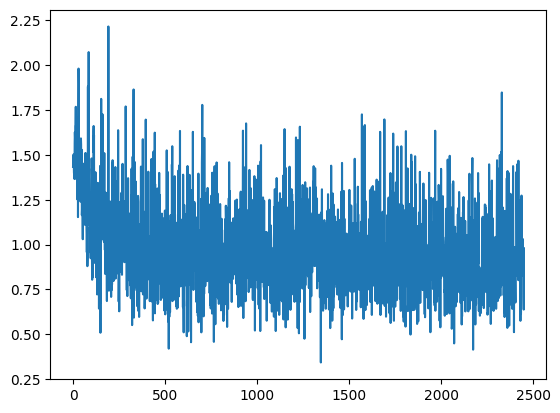

In [29]:
plt.plot(train_losses)

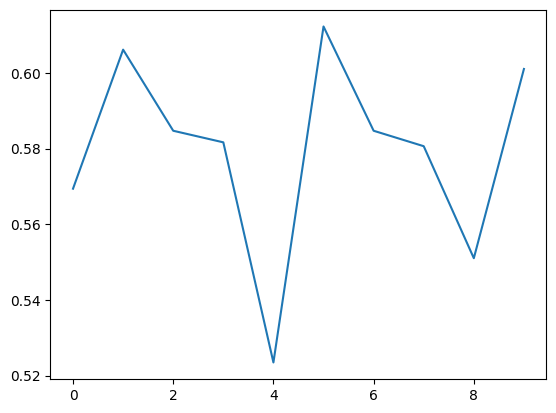

In [30]:
plt.plot(test_accuracy)

In [31]:
layer = model.fe_blocks.blocks[0].block.layer
named_params = [p for p in layer.named_parameters()]
named_params

[('lowcut_bands',
  Parameter containing:
  tensor([[ 0.0000],
          [-0.0087],
          [-0.0605],
          [-0.0129],
          [-0.0444],
          [-0.0144],
          [-0.0010],
          [-0.0599],
          [ 0.1644],
          [-0.0109],
          [-0.0406],
          [ 0.1356],
          [-0.0070],
          [-0.1053],
          [-0.0124],
          [ 0.0393],
          [-0.0294],
          [-0.1163],
          [ 0.0175],
          [ 0.0210],
          [ 0.1502],
          [-0.0959],
          [ 0.1820],
          [ 0.1087],
          [-0.1105],
          [ 0.0065],
          [ 0.0025],
          [ 0.2154],
          [ 0.0032],
          [ 0.1794],
          [-0.1258],
          [ 0.1452],
          [ 0.1892],
          [-0.1062],
          [ 0.1137],
          [ 0.0942],
          [ 0.1107],
          [ 0.2269],
          [ 0.1769],
          [-0.0246],
          [ 0.1141],
          [ 0.3573],
          [ 0.1679],
          [ 0.0808],
          [ 0.1172],
          [ 0

In [32]:
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [ 8.7167e-04],
        [-2.6497e-03],
        [-4.7688e-02],
        [-7.9533e-03],
        [-5.2894e-02],
        [-7.0451e-02],
        [-2.0339e-02],
        [ 3.8796e-02],
        [-2.5833e-02],
        [-6.6711e-02],
        [-1.7803e-02],
        [-5.8913e-02],
        [ 8.2829e-03],
        [-5.3648e-02],
        [ 1.9267e-02],
        [-6.6030e-02],
        [-6.7038e-03],
        [-1.4729e-02],
        [ 3.6183e-02],
        [ 1.0840e-02],
        [-2.3206e-02],
        [ 3.2237e-02],
        [-1.1009e-02],
        [ 3.0630e-02],
        [ 5.5261e-02],
        [ 2.3407e-02],
        [-3.0627e-02],
        [ 5.4219e-02],
        [-1.6638e-02],
        [-3.7449e-03],
        [-1.2014e-02],
        [ 2.4873e-03],
        [ 7.3065e-04],
        [-1.1773e-02],
        [ 2.4055e-02],
        [-1.8203e-02],
        [ 3.7015e-03],
        [-2.2534e-02],
        [-7.6304e-03],
        [-3.7080e-03],
        [-2.6792e-03],
        [ 7.9607e-03],
        [ 1

[None, None]

(array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  2.,  2.,  6.,  7.,  0.,  4.,
         7., 10., 14.,  2.,  4.,  2., 10., 13.,  8.,  9., 17.,  7.,  2.,
         7.,  6.,  5.,  2., 10.,  7.,  8., 12.,  0.,  0.,  0.,  4.,  3.,
         6.]),
 array([-0.32957748, -0.30822834, -0.28687924, -0.26553011, -0.24418099,
        -0.22283186, -0.20148274, -0.18013363, -0.15878449, -0.13743538,
        -0.11608625, -0.09473713, -0.07338801, -0.05203889, -0.03068976,
        -0.00934064,  0.01200848,  0.03335761,  0.05470673,  0.07605585,
         0.09740497,  0.1187541 ,  0.14010322,  0.16145234,  0.18280146,
         0.20415059,  0.2254997 ,  0.24684882,  0.26819795,  0.28954709,
         0.31089619,  0.33224532,  0.35359445,  0.37494355,  0.39629269,
         0.41764182,  0.43899092,  0.46034005,  0.48168918,  0.50303829,
         0.52438742]),
 <BarContainer object of 40 artists>)

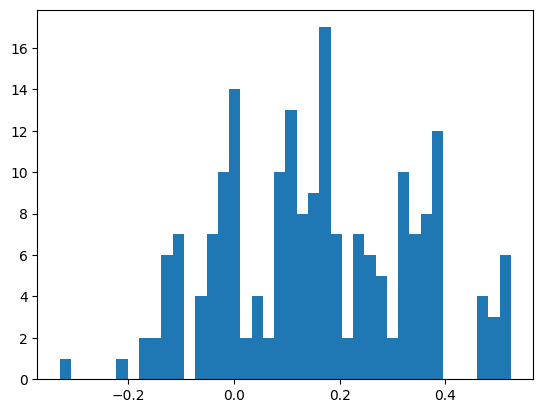

In [33]:
lowcut_bands = named_params[0][1].detach().cpu().numpy()
plt.hist(lowcut_bands.flatten(), bins=40)

(array([ 1.,  0.,  0.,  0.,  0.,  1.,  3.,  4.,  0.,  2.,  2.,  0.,  5.,
         6.,  4.,  9., 12., 15., 11., 19., 19., 21.,  8., 18., 11.,  5.,
         7.,  5.,  4.,  3.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([-0.09707836, -0.09228724, -0.08749612, -0.082705  , -0.07791388,
        -0.07312275, -0.06833164, -0.06354052, -0.05874939, -0.05395827,
        -0.04916715, -0.04437603, -0.03958491, -0.03479379, -0.03000267,
        -0.02521155, -0.02042043, -0.01562931, -0.01083819, -0.00604707,
        -0.00125594,  0.00353518,  0.0083263 ,  0.01311742,  0.01790854,
         0.02269966,  0.02749078,  0.0322819 ,  0.03707302,  0.04186414,
         0.04665526,  0.05144639,  0.0562375 ,  0.06102863,  0.06581975,
         0.07061087,  0.07540199,  0.08019311,  0.08498423,  0.08977535,
         0.09456647]),
 <BarContainer object of 40 artists>)

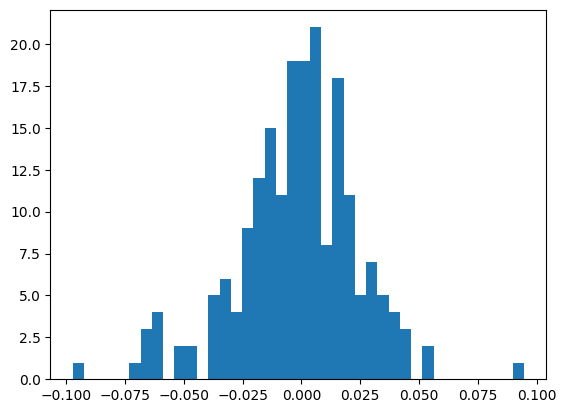

In [34]:
lowcut_bands_grad = named_params[0][1].grad.detach().cpu().numpy()
plt.hist(lowcut_bands_grad.flatten(), bins=40)

(array([ 1.,  0.,  0.,  0.,  2.,  0.,  0.,  1.,  0.,  3.,  3.,  5.,  3.,
         4.,  6.,  1.,  1.,  4.,  1.,  1.,  2.,  7., 14., 11.,  7., 10.,
        19., 17., 19., 13., 14.,  6.,  7.,  3.,  4.,  4.,  2.,  0.,  2.,
         1.]),
 array([-0.27852994, -0.26390794, -0.24928595, -0.23466396, -0.22004196,
        -0.20541997, -0.19079797, -0.17617598, -0.16155398, -0.14693199,
        -0.13231   , -0.117688  , -0.103066  , -0.08844401, -0.07382201,
        -0.05920002, -0.04457803, -0.02995603, -0.01533404, -0.00071204,
         0.01390995,  0.02853195,  0.04315394,  0.05777593,  0.07239793,
         0.08701992,  0.10164192,  0.11626391,  0.13088591,  0.1455079 ,
         0.1601299 ,  0.17475189,  0.18937388,  0.20399588,  0.21861787,
         0.23323987,  0.24786186,  0.26248387,  0.27710587,  0.29172784,
         0.30634984]),
 <BarContainer object of 40 artists>)

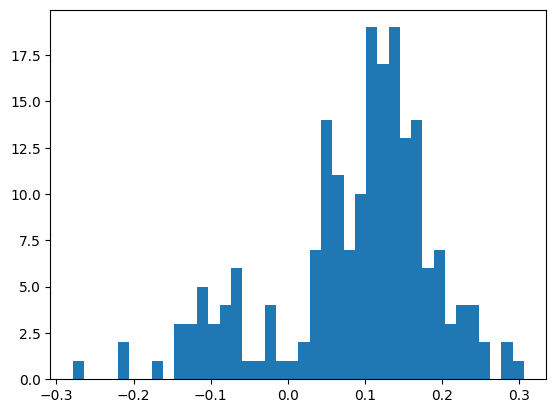

In [35]:
bandwidths = named_params[1][1].detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

(array([ 1.,  0.,  0.,  0.,  2.,  0.,  0.,  1.,  0.,  3.,  3.,  5.,  3.,
         4.,  6.,  1.,  1.,  4.,  1.,  1.,  2.,  7., 14., 11.,  7., 10.,
        19., 17., 19., 13., 14.,  6.,  7.,  3.,  4.,  4.,  2.,  0.,  2.,
         1.]),
 array([-0.27852994, -0.26390794, -0.24928595, -0.23466396, -0.22004196,
        -0.20541997, -0.19079797, -0.17617598, -0.16155398, -0.14693199,
        -0.13231   , -0.117688  , -0.103066  , -0.08844401, -0.07382201,
        -0.05920002, -0.04457803, -0.02995603, -0.01533404, -0.00071204,
         0.01390995,  0.02853195,  0.04315394,  0.05777593,  0.07239793,
         0.08701992,  0.10164192,  0.11626391,  0.13088591,  0.1455079 ,
         0.1601299 ,  0.17475189,  0.18937388,  0.20399588,  0.21861787,
         0.23323987,  0.24786186,  0.26248387,  0.27710587,  0.29172784,
         0.30634984]),
 <BarContainer object of 40 artists>)

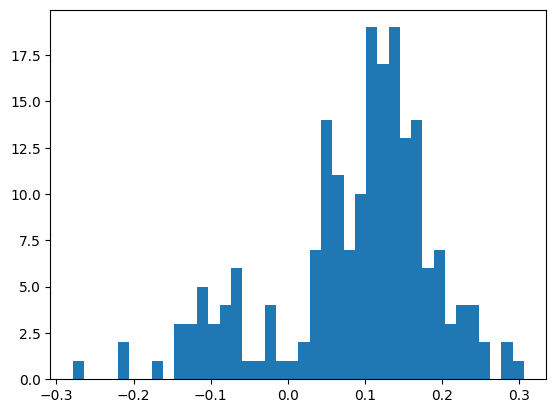

In [36]:
bandwidths_grad = named_params[1][1].grad.detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

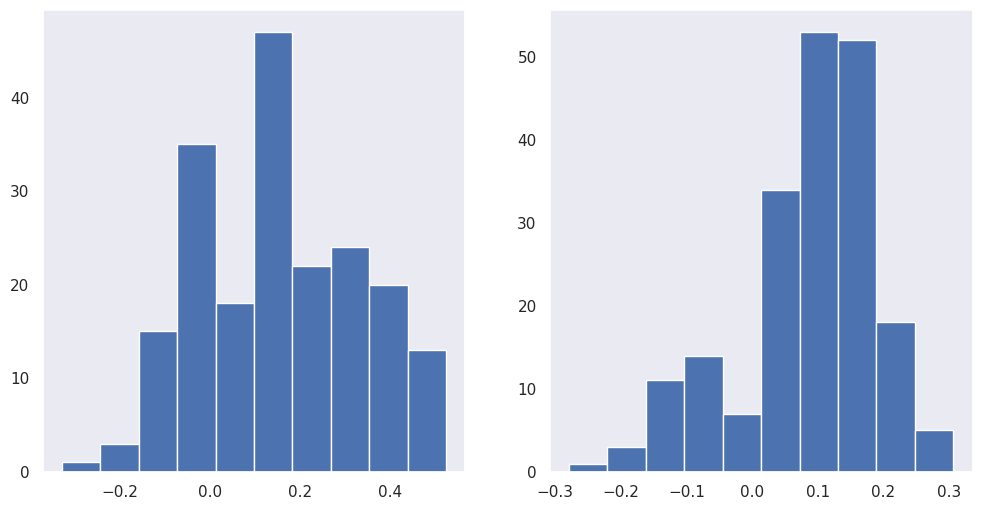

In [37]:
from IConNet.visualizer import visualize_model
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = None, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_bands()

(array([ 1.,  0.,  0.,  0.,  0.,  1.,  0.,  2.,  2.,  6.,  7.,  0.,  4.,
         7., 10., 14.,  2.,  4.,  2., 10., 13.,  8.,  9., 17.,  7.,  2.,
         7.,  6.,  5.,  2., 10.,  7.,  8., 12.,  0.,  0.,  0.,  4.,  3.,
         6.]),
 array([-0.32957748, -0.30822834, -0.28687924, -0.26553011, -0.24418099,
        -0.22283186, -0.20148274, -0.18013363, -0.15878449, -0.13743538,
        -0.11608625, -0.09473713, -0.07338801, -0.05203889, -0.03068976,
        -0.00934064,  0.01200848,  0.03335761,  0.05470673,  0.07605585,
         0.09740497,  0.1187541 ,  0.14010322,  0.16145234,  0.18280146,
         0.20415059,  0.2254997 ,  0.24684882,  0.26819795,  0.28954709,
         0.31089619,  0.33224532,  0.35359445,  0.37494355,  0.39629269,
         0.41764182,  0.43899092,  0.46034005,  0.48168918,  0.50303829,
         0.52438742]),
 <BarContainer object of 40 artists>)

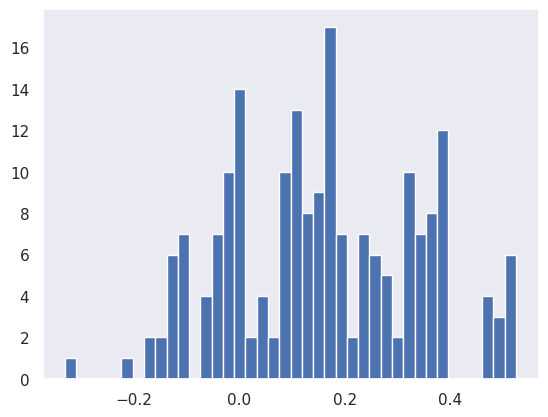

In [38]:
lowcut_bands = named_params[0][1].detach().cpu().numpy()
plt.hist(lowcut_bands.flatten(), bins=40)

(array([ 1.,  0.,  0.,  0.,  0.,  1.,  3.,  4.,  0.,  2.,  2.,  0.,  5.,
         6.,  4.,  9., 12., 15., 11., 19., 19., 21.,  8., 18., 11.,  5.,
         7.,  5.,  4.,  3.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.]),
 array([-0.09707836, -0.09228724, -0.08749612, -0.082705  , -0.07791388,
        -0.07312275, -0.06833164, -0.06354052, -0.05874939, -0.05395827,
        -0.04916715, -0.04437603, -0.03958491, -0.03479379, -0.03000267,
        -0.02521155, -0.02042043, -0.01562931, -0.01083819, -0.00604707,
        -0.00125594,  0.00353518,  0.0083263 ,  0.01311742,  0.01790854,
         0.02269966,  0.02749078,  0.0322819 ,  0.03707302,  0.04186414,
         0.04665526,  0.05144639,  0.0562375 ,  0.06102863,  0.06581975,
         0.07061087,  0.07540199,  0.08019311,  0.08498423,  0.08977535,
         0.09456647]),
 <BarContainer object of 40 artists>)

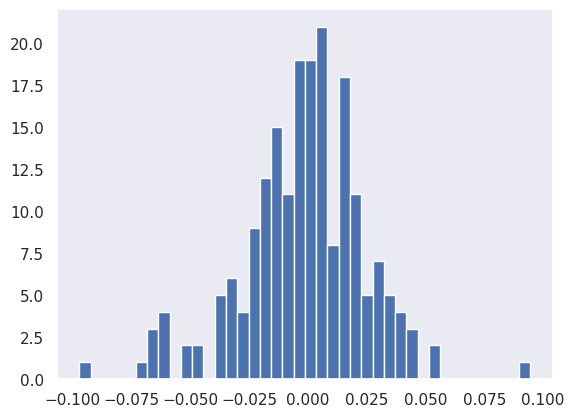

In [39]:
lowcut_bands_grad = named_params[0][1].grad.detach().cpu().numpy()
plt.hist(lowcut_bands_grad.flatten(), bins=40)

(array([ 1.,  0.,  0.,  0.,  2.,  0.,  0.,  1.,  0.,  3.,  3.,  5.,  3.,
         4.,  6.,  1.,  1.,  4.,  1.,  1.,  2.,  7., 14., 11.,  7., 10.,
        19., 17., 19., 13., 14.,  6.,  7.,  3.,  4.,  4.,  2.,  0.,  2.,
         1.]),
 array([-0.27852994, -0.26390794, -0.24928595, -0.23466396, -0.22004196,
        -0.20541997, -0.19079797, -0.17617598, -0.16155398, -0.14693199,
        -0.13231   , -0.117688  , -0.103066  , -0.08844401, -0.07382201,
        -0.05920002, -0.04457803, -0.02995603, -0.01533404, -0.00071204,
         0.01390995,  0.02853195,  0.04315394,  0.05777593,  0.07239793,
         0.08701992,  0.10164192,  0.11626391,  0.13088591,  0.1455079 ,
         0.1601299 ,  0.17475189,  0.18937388,  0.20399588,  0.21861787,
         0.23323987,  0.24786186,  0.26248387,  0.27710587,  0.29172784,
         0.30634984]),
 <BarContainer object of 40 artists>)

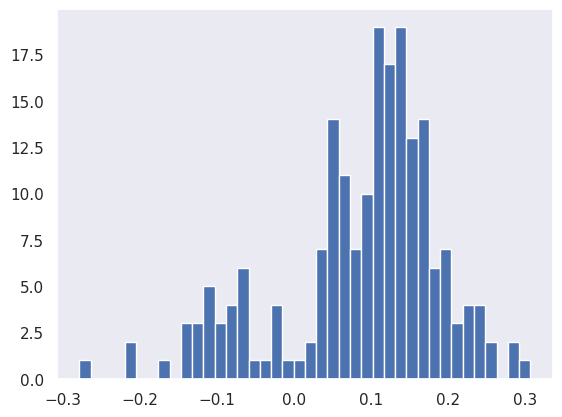

In [40]:
bandwidths = named_params[1][1].detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

(array([ 1.,  0.,  0.,  0.,  2.,  0.,  0.,  1.,  0.,  3.,  3.,  5.,  3.,
         4.,  6.,  1.,  1.,  4.,  1.,  1.,  2.,  7., 14., 11.,  7., 10.,
        19., 17., 19., 13., 14.,  6.,  7.,  3.,  4.,  4.,  2.,  0.,  2.,
         1.]),
 array([-0.27852994, -0.26390794, -0.24928595, -0.23466396, -0.22004196,
        -0.20541997, -0.19079797, -0.17617598, -0.16155398, -0.14693199,
        -0.13231   , -0.117688  , -0.103066  , -0.08844401, -0.07382201,
        -0.05920002, -0.04457803, -0.02995603, -0.01533404, -0.00071204,
         0.01390995,  0.02853195,  0.04315394,  0.05777593,  0.07239793,
         0.08701992,  0.10164192,  0.11626391,  0.13088591,  0.1455079 ,
         0.1601299 ,  0.17475189,  0.18937388,  0.20399588,  0.21861787,
         0.23323987,  0.24786186,  0.26248387,  0.27710587,  0.29172784,
         0.30634984]),
 <BarContainer object of 40 artists>)

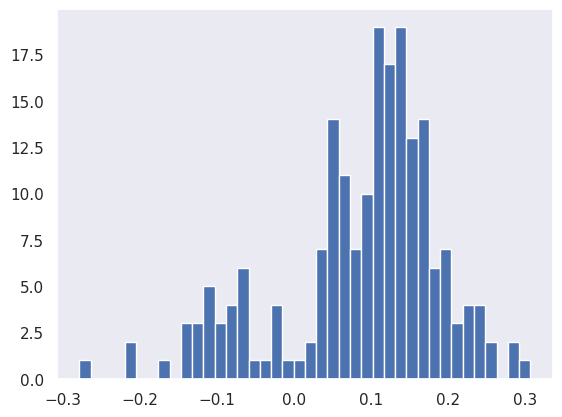

In [41]:
bandwidths_grad = named_params[1][1].grad.detach().cpu().numpy()
plt.hist(bandwidths.flatten(), bins=40)

In [42]:
windows = torch.full_like(layer.lowcut_bands, 0.5).repeat(1,1,2)
windows.shape

torch.Size([1, 198, 2])

Time domain: Filters' shapes vary by frequency bins


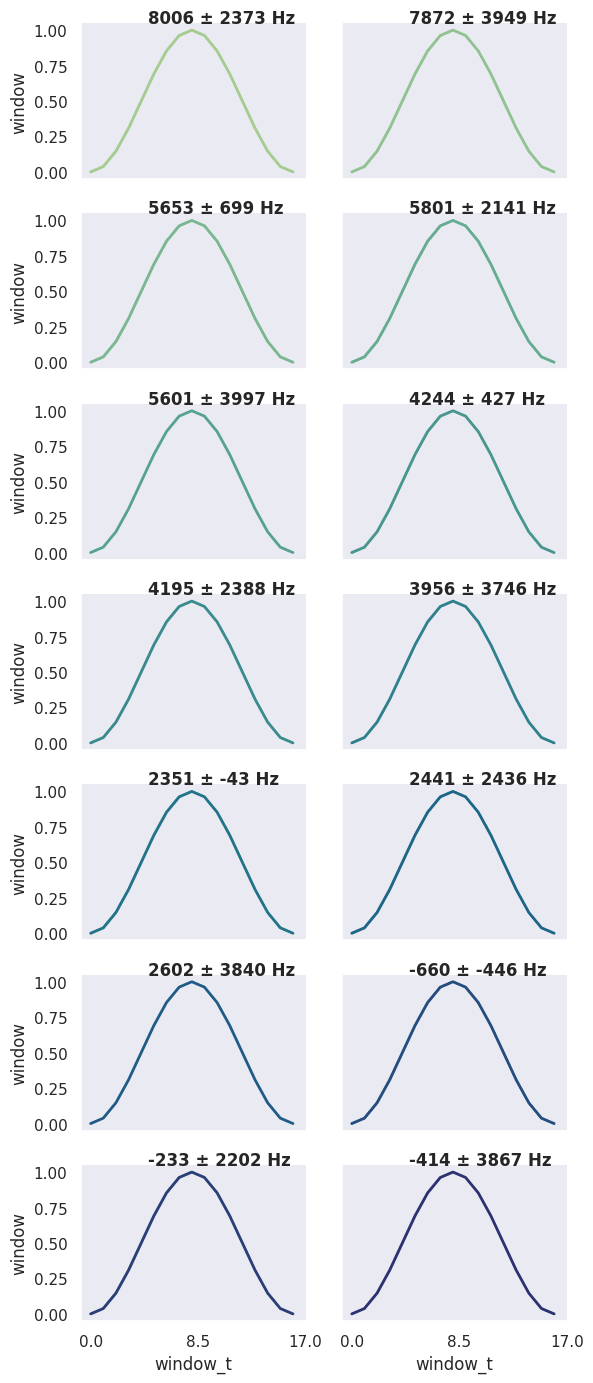

In [43]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = windows, 
    window_length = 64,
    sample_rate = sr
)

filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


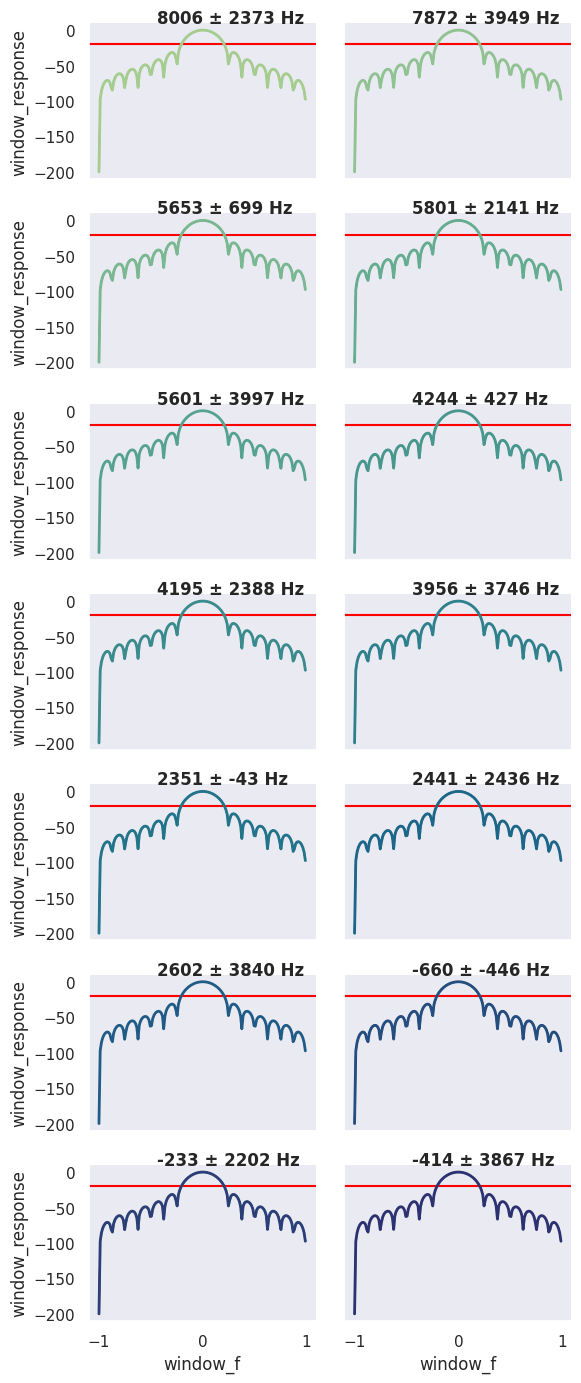

In [44]:
filtviz.visualize_filters(filter_domain='freq')

In [45]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),    
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [46]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 589/976 (0.6035)
{'acc_detail': tensor([0.7826, 0.5853, 0.7402, 0.3016], device='cuda:0'),
 'acc_unweighted': tensor(0.6024, device='cuda:0'),
 'acc_weighted': tensor(0.6035, device='cuda:0'),
 'f1s_detail': tensor([0.7226, 0.5303, 0.7245, 0.3744], device='cuda:0'),
 'f1s_unweighted': tensor(0.5879, device='cuda:0'),
 'f1s_weighted': tensor(0.5904, device='cuda:0'),
 'precision_detail': tensor([0.6712, 0.4847, 0.7094, 0.4935], device='cuda:0'),
 'recall_detail': tensor([0.7826, 0.5853, 0.7402, 0.3016], device='cuda:0'),
 'rocauc': tensor(0.8566, device='cuda:0'),
 'rocauc_detail': tensor([0.9165, 0.8375, 0.9144, 0.7578], device='cuda:0'),
 'uar': tensor(0.6024, device='cuda:0'),
 'wap': tensor(0.5938, device='cuda:0')}


tensor([[198,  12,   1,  42],
        [  4, 127,  57,  29],
        [  4,  55, 188,   7],
        [ 89,  68,  19,  76]], device='cuda:0')

In [47]:
n_epoch = 10
n_epoch2 = 50
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_cremad4/cremad_label4_m14sinc_fixed_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                   | 0.0032679738562091504/50 [00:00<1:45:09, 126.21s/it]

Train Epoch: 11 [0/3920 (0%)]	Loss: 0.776321
Mem before-during-after: 23830016 3968382464 27004416


  0%|▏                                                                     | 0.1339869281045752/50 [00:16<1:55:36, 139.10s/it]

Train Epoch: 11 [640/3920 (16%)]	Loss: 1.005864
Mem before-during-after: 27004416 3971873280 27004416


  1%|▎                                                                    | 0.26470588235294074/50 [00:33<2:00:05, 144.87s/it]

Train Epoch: 11 [1280/3920 (33%)]	Loss: 0.570561
Mem before-during-after: 27004416 3971873280 27004416


  1%|▌                                                                     | 0.3954248366013063/50 [00:50<1:55:04, 139.19s/it]

Train Epoch: 11 [1920/3920 (49%)]	Loss: 0.718100
Mem before-during-after: 27004416 3971873280 27004416


  1%|▋                                                                     | 0.5261437908496719/50 [01:06<1:54:09, 138.44s/it]

Train Epoch: 11 [2560/3920 (65%)]	Loss: 0.934497
Mem before-during-after: 27004416 3970706944 27004416


  1%|▉                                                                     | 0.6568627450980374/50 [01:23<1:56:14, 141.35s/it]

Train Epoch: 11 [3200/3920 (82%)]	Loss: 0.778161
Mem before-during-after: 27004416 3971873280 27004416


  2%|█                                                                      | 0.787581699346403/50 [01:39<1:53:34, 138.47s/it]

Train Epoch: 11 [3840/3920 (98%)]	Loss: 1.083935
Mem before-during-after: 27004416 3971873280 27004416


  2%|█▍                                                                      | 0.999999999999997/50 [01:57<1:04:29, 78.97s/it]


Test Epoch: 11	Accuracy: 591/976 (60%)

saved model: ../models_cremad4/cremad_label4_m14sinc_fixed_best_11epoch.pt


  2%|█▍                                                                     | 1.0032679738562063/50 [01:57<1:16:19, 93.46s/it]

Train Epoch: 12 [0/3920 (0%)]	Loss: 0.898992
Mem before-during-after: 27003392 3971555840 27004416


  2%|█▌                                                                    | 1.1339869281045718/50 [02:14<1:53:13, 139.03s/it]

Train Epoch: 12 [640/3920 (16%)]	Loss: 0.773773
Mem before-during-after: 27004416 3971873280 27004416


  3%|█▊                                                                    | 1.2647058823529373/50 [02:30<1:53:24, 139.62s/it]

Train Epoch: 12 [1280/3920 (33%)]	Loss: 0.796389
Mem before-during-after: 27004416 3972135424 27004416


  3%|█▉                                                                     | 1.395424836601303/50 [02:47<1:53:19, 139.90s/it]

Train Epoch: 12 [1920/3920 (49%)]	Loss: 0.596851
Mem before-during-after: 27004416 3972073472 27004416


  3%|██▏                                                                   | 1.5261437908496684/50 [03:03<1:53:14, 140.18s/it]

Train Epoch: 12 [2560/3920 (65%)]	Loss: 1.124370
Mem before-during-after: 27004416 3972135424 27004416


  3%|██▎                                                                    | 1.656862745098034/50 [03:20<1:52:47, 139.99s/it]

Train Epoch: 12 [3200/3920 (82%)]	Loss: 1.008239
Mem before-during-after: 27004416 3972135424 27004416


  4%|██▌                                                                   | 1.7875816993463995/50 [03:36<1:52:15, 139.71s/it]

Train Epoch: 12 [3840/3920 (98%)]	Loss: 0.867042
Mem before-during-after: 27004416 3972397568 27004416


  4%|██▊                                                                    | 1.9999999999999936/50 [03:54<1:03:39, 79.58s/it]


Test Epoch: 12	Accuracy: 602/976 (61%)

saved model: ../models_cremad4/cremad_label4_m14sinc_fixed_best_12epoch.pt


  4%|██▉                                                                     | 2.003267973856203/50 [03:54<1:15:13, 94.04s/it]

Train Epoch: 13 [0/3920 (0%)]	Loss: 0.458428
Mem before-during-after: 27003392 3971555840 27004416


  4%|██▉                                                                   | 2.1339869281045685/50 [04:11<1:54:00, 142.91s/it]

Train Epoch: 13 [640/3920 (16%)]	Loss: 1.072706
Mem before-during-after: 27004416 3972135424 27004416


  5%|███▏                                                                   | 2.264705882352934/50 [04:28<1:55:01, 144.58s/it]

Train Epoch: 13 [1280/3920 (33%)]	Loss: 0.832103
Mem before-during-after: 27004416 3970706432 27004416


  5%|███▎                                                                  | 2.3954248366012996/50 [04:44<1:51:41, 140.78s/it]

Train Epoch: 13 [1920/3920 (49%)]	Loss: 0.835761
Mem before-during-after: 27004416 3972397568 27004416


  5%|███▌                                                                   | 2.526143790849665/50 [05:01<1:51:44, 141.24s/it]

Train Epoch: 13 [2560/3920 (65%)]	Loss: 1.326350
Mem before-during-after: 27004416 3971873280 27004416


  5%|███▋                                                                  | 2.6568627450980307/50 [05:18<1:51:48, 141.70s/it]

Train Epoch: 13 [3200/3920 (82%)]	Loss: 0.921188
Mem before-during-after: 27004416 3972397568 27004416


  6%|███▉                                                                   | 2.787581699346396/50 [05:34<1:49:54, 139.68s/it]

Train Epoch: 13 [3840/3920 (98%)]	Loss: 0.888317
Mem before-during-after: 27004416 3973929472 27329024


  6%|████▎                                                                  | 2.9999999999999902/50 [05:52<1:01:21, 78.32s/it]


Test Epoch: 13	Accuracy: 600/976 (61%)



  6%|████▎                                                                  | 3.0032679738561994/50 [05:52<1:12:24, 92.43s/it]

Train Epoch: 14 [0/3920 (0%)]	Loss: 0.738389
Mem before-during-after: 27003392 3889210368 27004416


  6%|████▍                                                                  | 3.133986928104565/50 [06:09<1:48:29, 138.90s/it]

Train Epoch: 14 [640/3920 (16%)]	Loss: 0.908471
Mem before-during-after: 27004416 3765149184 27004416


  7%|████▌                                                                 | 3.2647058823529305/50 [06:25<1:46:57, 137.31s/it]

Train Epoch: 14 [1280/3920 (33%)]	Loss: 1.185387
Mem before-during-after: 27004416 3972377600 27004416


  7%|████▊                                                                  | 3.395424836601296/50 [06:41<1:47:44, 138.71s/it]

Train Epoch: 14 [1920/3920 (49%)]	Loss: 0.815004
Mem before-during-after: 27004416 3972397568 27004416


  7%|████▉                                                                 | 3.5261437908496616/50 [06:58<1:47:34, 138.89s/it]

Train Epoch: 14 [2560/3920 (65%)]	Loss: 1.154241
Mem before-during-after: 27004416 3970706432 27004416


  7%|█████▏                                                                 | 3.656862745098027/50 [07:14<1:47:32, 139.24s/it]

Train Epoch: 14 [3200/3920 (82%)]	Loss: 0.693725
Mem before-during-after: 27004416 3941472256 27004416


  8%|█████▎                                                                | 3.7875816993463927/50 [07:31<1:46:57, 138.87s/it]

Train Epoch: 14 [3840/3920 (98%)]	Loss: 0.531490
Mem before-during-after: 27004416 3972397568 27004416


  8%|█████▊                                                                   | 3.9999999999999867/50 [07:48<59:50, 78.05s/it]


Test Epoch: 14	Accuracy: 608/976 (62%)

saved model: ../models_cremad4/cremad_label4_m14sinc_fixed_best_14epoch.pt


  8%|█████▊                                                                  | 4.003267973856196/50 [07:48<1:11:00, 92.62s/it]

Train Epoch: 15 [0/3920 (0%)]	Loss: 0.701151
Mem before-during-after: 27003392 3971555840 27004416


  8%|█████▊                                                                 | 4.133986928104561/50 [08:05<1:49:25, 143.15s/it]

Train Epoch: 15 [640/3920 (16%)]	Loss: 0.887237
Mem before-during-after: 27004416 3972072960 27004416


  9%|██████                                                                 | 4.264705882352927/50 [08:22<1:47:17, 140.75s/it]

Train Epoch: 15 [1280/3920 (33%)]	Loss: 0.965291
Mem before-during-after: 27004416 3970706432 27004416


  9%|██████▏                                                               | 4.3954248366012925/50 [08:38<1:46:19, 139.89s/it]

Train Epoch: 15 [1920/3920 (49%)]	Loss: 1.247256
Mem before-during-after: 27004416 3972397568 27004416


  9%|██████▍                                                                | 4.526143790849658/50 [08:55<1:46:36, 140.66s/it]

Train Epoch: 15 [2560/3920 (65%)]	Loss: 0.809144
Mem before-during-after: 27004416 3972397568 27004416


  9%|██████▌                                                                | 4.656862745098024/50 [09:12<1:45:06, 139.08s/it]

Train Epoch: 15 [3200/3920 (82%)]	Loss: 1.016540
Mem before-during-after: 27004416 3972128768 27004416


 10%|██████▊                                                                | 4.787581699346389/50 [09:28<1:44:45, 139.02s/it]

Train Epoch: 15 [3840/3920 (98%)]	Loss: 1.046504
Mem before-during-after: 27004416 3972397568 27004416


 10%|███████▍                                                                  | 4.999999999999983/50 [09:46<59:13, 78.97s/it]


Test Epoch: 15	Accuracy: 594/976 (61%)



 10%|███████▏                                                                | 5.003267973856192/50 [09:46<1:09:58, 93.30s/it]

Train Epoch: 16 [0/3920 (0%)]	Loss: 0.921414
Mem before-during-after: 27003392 3971555840 27004416


 10%|███████▎                                                               | 5.133986928104558/50 [10:02<1:43:41, 138.66s/it]

Train Epoch: 16 [640/3920 (16%)]	Loss: 0.616855
Mem before-during-after: 27004416 3971873280 27004416


 11%|███████▍                                                               | 5.264705882352923/50 [10:19<1:43:59, 139.47s/it]

Train Epoch: 16 [1280/3920 (33%)]	Loss: 1.114061
Mem before-during-after: 27004416 3972397568 27004416


 11%|███████▋                                                               | 5.395424836601289/50 [10:35<1:43:15, 138.89s/it]

Train Epoch: 16 [1920/3920 (49%)]	Loss: 1.089437
Mem before-during-after: 27004416 3942945280 27004416


 11%|███████▋                                                              | 5.5261437908496545/50 [10:52<1:43:26, 139.56s/it]

Train Epoch: 16 [2560/3920 (65%)]	Loss: 0.867425
Mem before-during-after: 27004416 3972397568 27004416


 11%|████████▏                                                               | 5.65686274509802/50 [11:08<1:41:59, 138.01s/it]

Train Epoch: 16 [3200/3920 (82%)]	Loss: 0.979523
Mem before-during-after: 27004416 3972397568 27004416


 12%|████████                                                              | 5.7875816993463856/50 [11:25<1:42:43, 139.42s/it]

Train Epoch: 16 [3840/3920 (98%)]	Loss: 0.795492
Mem before-during-after: 27004416 3972397568 27004416


 12%|████████▉                                                                  | 5.99999999999998/50 [11:42<57:36, 78.55s/it]


Test Epoch: 16	Accuracy: 603/976 (62%)



 12%|████████▋                                                               | 6.003267973856189/50 [11:42<1:08:11, 93.00s/it]

Train Epoch: 17 [0/3920 (0%)]	Loss: 0.715228
Mem before-during-after: 27003392 3971555840 27004416


 12%|████████▋                                                              | 6.133986928104554/50 [11:59<1:40:40, 137.70s/it]

Train Epoch: 17 [640/3920 (16%)]	Loss: 1.046952
Mem before-during-after: 27004416 3640288768 27004416


 13%|█████████                                                               | 6.26470588235292/50 [12:15<1:42:07, 140.09s/it]

Train Epoch: 17 [1280/3920 (33%)]	Loss: 0.890530
Mem before-during-after: 27004416 3972397568 27004416


 13%|█████████                                                              | 6.395424836601285/50 [12:32<1:41:05, 139.11s/it]

Train Epoch: 17 [1920/3920 (49%)]	Loss: 0.523400
Mem before-during-after: 27129344 3970991616 27004416


 13%|█████████▎                                                             | 6.526143790849651/50 [12:48<1:39:58, 137.99s/it]

Train Epoch: 17 [2560/3920 (65%)]	Loss: 0.851291
Mem before-during-after: 27004416 3682238464 27004416


 13%|█████████▎                                                            | 6.6568627450980165/50 [13:05<1:39:48, 138.17s/it]

Train Epoch: 17 [3200/3920 (82%)]	Loss: 0.647773
Mem before-during-after: 27004416 3882942976 27437568


 14%|█████████▋                                                             | 6.787581699346382/50 [13:21<1:39:36, 138.32s/it]

Train Epoch: 17 [3840/3920 (98%)]	Loss: 0.628329
Mem before-during-after: 27004416 3971873280 27004416


 14%|██████████▎                                                               | 6.999999999999976/50 [13:39<55:56, 78.05s/it]


Test Epoch: 17	Accuracy: 612/976 (62%)

saved model: ../models_cremad4/cremad_label4_m14sinc_fixed_best_17epoch.pt


 14%|██████████                                                              | 7.003267973856185/50 [13:39<1:06:42, 93.08s/it]

Train Epoch: 18 [0/3920 (0%)]	Loss: 0.689636
Mem before-during-after: 27003392 3971556352 27004416


 14%|██████████▏                                                            | 7.133986928104551/50 [13:55<1:39:11, 138.83s/it]

Train Epoch: 18 [640/3920 (16%)]	Loss: 0.641430
Mem before-during-after: 27004416 3972397568 27004416


 15%|██████████▎                                                            | 7.264705882352916/50 [14:12<1:38:46, 138.67s/it]

Train Epoch: 18 [1280/3920 (33%)]	Loss: 0.818534
Mem before-during-after: 27004416 3972397568 27004416


 15%|██████████▌                                                            | 7.395424836601282/50 [14:28<1:38:47, 139.14s/it]

Train Epoch: 18 [1920/3920 (49%)]	Loss: 0.890670
Mem before-during-after: 27004416 3764230656 27004416


 15%|██████████▋                                                            | 7.526143790849647/50 [14:45<1:39:34, 140.67s/it]

Train Epoch: 18 [2560/3920 (65%)]	Loss: 0.848083
Mem before-during-after: 27004416 3972397568 27004416


 15%|██████████▊                                                            | 7.656862745098013/50 [15:02<1:40:41, 142.69s/it]

Train Epoch: 18 [3200/3920 (82%)]	Loss: 0.763240
Mem before-during-after: 27004416 3972135424 27004416


 16%|██████████▉                                                           | 7.7875816993463784/50 [15:18<1:38:20, 139.79s/it]

Train Epoch: 18 [3840/3920 (98%)]	Loss: 1.466390
Mem before-during-after: 27004416 3971873280 27004416


 16%|███████████▋                                                             | 7.9999999999999725/50 [15:36<55:42, 79.58s/it]


Test Epoch: 18	Accuracy: 606/976 (62%)



 16%|███████████▌                                                            | 8.003267973856182/50 [15:36<1:05:47, 94.00s/it]

Train Epoch: 19 [0/3920 (0%)]	Loss: 0.658441
Mem before-during-after: 27003392 3971556352 27004416


 16%|███████████▌                                                           | 8.133986928104548/50 [15:53<1:36:30, 138.31s/it]

Train Epoch: 19 [640/3920 (16%)]	Loss: 1.245512
Mem before-during-after: 27004416 3882509824 27004416


 17%|███████████▋                                                           | 8.264705882352914/50 [16:09<1:36:49, 139.20s/it]

Train Epoch: 19 [1280/3920 (33%)]	Loss: 0.658422
Mem before-during-after: 27004416 3972397568 27004416


 17%|████████████                                                            | 8.39542483660128/50 [16:26<1:36:17, 138.87s/it]

Train Epoch: 19 [1920/3920 (49%)]	Loss: 0.988043
Mem before-during-after: 27004416 3723201024 27004416


 17%|████████████                                                           | 8.526143790849645/50 [16:42<1:40:48, 145.83s/it]

Train Epoch: 19 [2560/3920 (65%)]	Loss: 1.222486
Mem before-during-after: 27004416 3971873280 27004416


 17%|████████████▍                                                           | 8.65686274509801/50 [16:59<1:36:16, 139.72s/it]

Train Epoch: 19 [3200/3920 (82%)]	Loss: 0.733439
Mem before-during-after: 27004416 3972397568 27004416


 18%|████████████▍                                                          | 8.787581699346376/50 [17:15<1:35:33, 139.12s/it]

Train Epoch: 19 [3840/3920 (98%)]	Loss: 0.849448
Mem before-during-after: 27004416 3972609536 27004416


 18%|█████████████▍                                                             | 8.99999999999997/50 [17:33<54:01, 79.07s/it]


Test Epoch: 19	Accuracy: 604/976 (62%)



 18%|████████████▉                                                           | 9.003267973856179/50 [17:33<1:03:50, 93.43s/it]

Train Epoch: 20 [0/3920 (0%)]	Loss: 0.813136
Mem before-during-after: 27003392 3971555840 27004416


 18%|████████████▉                                                          | 9.133986928104544/50 [17:50<1:34:03, 138.11s/it]

Train Epoch: 20 [640/3920 (16%)]	Loss: 1.102204
Mem before-during-after: 27004416 3882942976 27004416


 19%|█████████████▎                                                          | 9.26470588235291/50 [18:06<1:34:30, 139.19s/it]

Train Epoch: 20 [1280/3920 (33%)]	Loss: 0.771084
Mem before-during-after: 27004416 3805655040 27004416


 19%|█████████████▎                                                         | 9.395424836601276/50 [18:22<1:33:38, 138.37s/it]

Train Epoch: 20 [1920/3920 (49%)]	Loss: 1.059505
Mem before-during-after: 27004416 3971873280 27004416


 19%|█████████████▌                                                         | 9.526143790849641/50 [18:39<1:33:02, 137.94s/it]

Train Epoch: 20 [2560/3920 (65%)]	Loss: 0.504655
Mem before-during-after: 27004416 3971283456 27004416


 19%|█████████████▋                                                         | 9.656862745098007/50 [18:55<1:33:22, 138.86s/it]

Train Epoch: 20 [3200/3920 (82%)]	Loss: 0.579847
Mem before-during-after: 27004416 3972397568 27004416


 20%|█████████████▉                                                         | 9.787581699346372/50 [19:12<1:32:59, 138.75s/it]

Train Epoch: 20 [3840/3920 (98%)]	Loss: 1.011705
Mem before-during-after: 27004416 3970706944 27004416


 20%|██████████████▊                                                           | 9.999999999999966/50 [19:29<52:02, 78.07s/it]


Test Epoch: 20	Accuracy: 604/976 (62%)



 20%|██████████████▏                                                        | 10.003267973856175/50 [19:29<1:01:36, 92.43s/it]

Train Epoch: 21 [0/3920 (0%)]	Loss: 0.880229
Mem before-during-after: 27003392 3971555840 27004416


 20%|██████████████▏                                                       | 10.133986928104541/50 [19:46<1:33:44, 141.09s/it]

Train Epoch: 21 [640/3920 (16%)]	Loss: 0.563534
Mem before-during-after: 27004416 3970706432 27004416


 21%|██████████████▎                                                       | 10.264705882352906/50 [20:02<1:31:47, 138.60s/it]

Train Epoch: 21 [1280/3920 (33%)]	Loss: 0.879624
Mem before-during-after: 27004416 3970706432 27004416


 21%|██████████████▌                                                       | 10.395424836601272/50 [20:19<1:31:29, 138.60s/it]

Train Epoch: 21 [1920/3920 (49%)]	Loss: 0.890594
Mem before-during-after: 27004416 3970706432 27129344


 21%|██████████████▋                                                       | 10.526143790849638/50 [20:35<1:31:45, 139.46s/it]

Train Epoch: 21 [2560/3920 (65%)]	Loss: 1.130727
Mem before-during-after: 27004416 3972397568 27004416


 21%|██████████████▉                                                       | 10.656862745098003/50 [20:52<1:30:56, 138.70s/it]

Train Epoch: 21 [3200/3920 (82%)]	Loss: 1.001001
Mem before-during-after: 27004416 3972397568 27004416


 22%|███████████████                                                       | 10.787581699346369/50 [21:08<1:31:06, 139.41s/it]

Train Epoch: 21 [3840/3920 (98%)]	Loss: 1.016197
Mem before-during-after: 27004416 3971588096 27129344


 22%|████████████████                                                         | 10.999999999999963/50 [21:25<51:23, 79.08s/it]


Test Epoch: 21	Accuracy: 604/976 (62%)



 22%|███████████████▌                                                       | 11.003267973856172/50 [21:26<1:00:39, 93.34s/it]

Train Epoch: 22 [0/3920 (0%)]	Loss: 0.831408
Mem before-during-after: 27003392 3971556352 27004416


 22%|███████████████▌                                                      | 11.133986928104537/50 [21:42<1:30:03, 139.02s/it]

Train Epoch: 22 [640/3920 (16%)]	Loss: 0.894365
Mem before-during-after: 27004416 3972072960 27004416


 23%|███████████████▊                                                      | 11.264705882352903/50 [21:59<1:29:21, 138.40s/it]

Train Epoch: 22 [1280/3920 (33%)]	Loss: 0.659081
Mem before-during-after: 27004416 3972397568 27004416


 23%|███████████████▉                                                      | 11.395424836601268/50 [22:15<1:29:42, 139.42s/it]

Train Epoch: 22 [1920/3920 (49%)]	Loss: 0.673245
Mem before-during-after: 27004416 3971873280 27004416


 23%|████████████████▏                                                     | 11.526143790849634/50 [22:32<1:29:33, 139.66s/it]

Train Epoch: 22 [2560/3920 (65%)]	Loss: 0.797838
Mem before-during-after: 27004416 3972073472 27004416


 23%|█████████████████                                                        | 11.656862745098/50 [22:48<1:29:14, 139.64s/it]

Train Epoch: 22 [3200/3920 (82%)]	Loss: 0.758888
Mem before-during-after: 27004416 3806259712 27004416


 24%|████████████████▌                                                     | 11.787581699346365/50 [23:05<1:28:59, 139.72s/it]

Train Epoch: 22 [3840/3920 (98%)]	Loss: 0.628467
Mem before-during-after: 27004416 3970706432 27004416


 24%|█████████████████▊                                                        | 11.99999999999996/50 [23:22<49:45, 78.57s/it]


Test Epoch: 22	Accuracy: 621/976 (63%)

saved model: ../models_cremad4/cremad_label4_m14sinc_fixed_best_22epoch.pt


 24%|█████████████████▌                                                       | 12.003267973856168/50 [23:23<59:21, 93.74s/it]

Train Epoch: 23 [0/3920 (0%)]	Loss: 0.788424
Mem before-during-after: 27003392 3971555840 27004416


 24%|████████████████▉                                                     | 12.133986928104534/50 [23:39<1:27:50, 139.19s/it]

Train Epoch: 23 [640/3920 (16%)]	Loss: 1.110079
Mem before-during-after: 27437568 3970706432 27004416


 25%|█████████████████▋                                                      | 12.2647058823529/50 [23:56<1:27:55, 139.80s/it]

Train Epoch: 23 [1280/3920 (33%)]	Loss: 1.084084
Mem before-during-after: 27149312 3942914048 27004416


 25%|█████████████████▎                                                    | 12.395424836601265/50 [24:12<1:27:02, 138.88s/it]

Train Epoch: 23 [1920/3920 (49%)]	Loss: 1.064340
Mem before-during-after: 27004416 3972397568 27004416


 25%|█████████████████▊                                                     | 12.52614379084963/50 [24:28<1:26:40, 138.77s/it]

Train Epoch: 23 [2560/3920 (65%)]	Loss: 0.643639
Mem before-during-after: 27004416 3972397568 27004416


 25%|█████████████████▋                                                    | 12.656862745097996/50 [24:45<1:27:08, 140.02s/it]

Train Epoch: 23 [3200/3920 (82%)]	Loss: 0.603363
Mem before-during-after: 27004416 3972397568 27004416


 26%|█████████████████▉                                                    | 12.787581699346362/50 [25:01<1:25:55, 138.55s/it]

Train Epoch: 23 [3840/3920 (98%)]	Loss: 0.695518
Mem before-during-after: 27004416 3970991616 27004416


 26%|██████████████████▉                                                      | 12.999999999999956/50 [25:19<48:18, 78.34s/it]


Test Epoch: 23	Accuracy: 598/976 (61%)



 26%|██████████████████▉                                                      | 13.003267973856165/50 [25:19<57:17, 92.92s/it]

Train Epoch: 24 [0/3920 (0%)]	Loss: 0.773648
Mem before-during-after: 27003392 3971555840 27004416


 26%|██████████████████▋                                                    | 13.13398692810453/50 [25:36<1:26:08, 140.19s/it]

Train Epoch: 24 [640/3920 (16%)]	Loss: 1.051258
Mem before-during-after: 27004416 3970381824 27004416


 27%|██████████████████▌                                                   | 13.264705882352896/50 [25:52<1:24:40, 138.31s/it]

Train Epoch: 24 [1280/3920 (33%)]	Loss: 0.718852
Mem before-during-after: 27004416 3972397568 27004416


 27%|██████████████████▊                                                   | 13.395424836601261/50 [26:08<1:25:06, 139.51s/it]

Train Epoch: 24 [1920/3920 (49%)]	Loss: 0.827064
Mem before-during-after: 27004416 3972397568 27004416


 27%|██████████████████▉                                                   | 13.526143790849627/50 [26:25<1:24:43, 139.37s/it]

Train Epoch: 24 [2560/3920 (65%)]	Loss: 0.889215
Mem before-during-after: 27004416 3972397568 27004416


 27%|███████████████████                                                   | 13.656862745097992/50 [26:41<1:23:59, 138.66s/it]

Train Epoch: 24 [3200/3920 (82%)]	Loss: 0.842272
Mem before-during-after: 27004416 3972397568 27004416


 28%|███████████████████▎                                                  | 13.787581699346358/50 [26:58<1:24:00, 139.20s/it]

Train Epoch: 24 [3840/3920 (98%)]	Loss: 0.893981
Mem before-during-after: 27004416 3972397568 27004416


 28%|████████████████████▍                                                    | 13.999999999999952/50 [27:15<47:45, 79.60s/it]


Test Epoch: 24	Accuracy: 609/976 (62%)



 28%|████████████████████▍                                                    | 14.003267973856161/50 [27:16<56:14, 93.76s/it]

Train Epoch: 25 [0/3920 (0%)]	Loss: 0.724750
Mem before-during-after: 27003392 3971555840 27004416


 28%|███████████████████▊                                                  | 14.133986928104527/50 [27:32<1:23:17, 139.35s/it]

Train Epoch: 25 [640/3920 (16%)]	Loss: 0.824307
Mem before-during-after: 27004416 3973511680 27329024


 29%|███████████████████▉                                                  | 14.264705882352892/50 [27:48<1:22:48, 139.05s/it]

Train Epoch: 25 [1280/3920 (33%)]	Loss: 0.675504
Mem before-during-after: 27004416 3972377600 27004416


 29%|████████████████████▏                                                 | 14.395424836601258/50 [28:05<1:23:28, 140.66s/it]

Train Epoch: 25 [1920/3920 (49%)]	Loss: 0.551819
Mem before-during-after: 27004416 3973421568 27004416


 29%|████████████████████▎                                                 | 14.526143790849623/50 [28:22<1:22:44, 139.95s/it]

Train Epoch: 25 [2560/3920 (65%)]	Loss: 0.860702
Mem before-during-after: 27004416 3972397568 27004416


 29%|████████████████████▌                                                 | 14.656862745097989/50 [28:38<1:21:51, 138.96s/it]

Train Epoch: 25 [3200/3920 (82%)]	Loss: 0.561156
Mem before-during-after: 27437568 3970706432 27004416


 30%|████████████████████▋                                                 | 14.787581699346354/50 [28:54<1:21:12, 138.36s/it]

Train Epoch: 25 [3840/3920 (98%)]	Loss: 0.717315
Mem before-during-after: 27004416 3972377600 27004416


 30%|█████████████████████▉                                                   | 14.999999999999948/50 [29:12<45:47, 78.50s/it]


Test Epoch: 25	Accuracy: 622/976 (63%)

saved model: ../models_cremad4/cremad_label4_m14sinc_fixed_best_25epoch.pt


 30%|█████████████████████▉                                                   | 15.003267973856158/50 [29:12<54:30, 93.46s/it]

Train Epoch: 26 [0/3920 (0%)]	Loss: 1.078856
Mem before-during-after: 27003392 3971555840 27004416


 30%|█████████████████████▏                                                | 15.133986928104523/50 [29:29<1:20:39, 138.80s/it]

Train Epoch: 26 [640/3920 (16%)]	Loss: 0.523285
Mem before-during-after: 27004416 3971748352 27004416


 31%|█████████████████████▎                                                | 15.264705882352889/50 [29:45<1:20:39, 139.32s/it]

Train Epoch: 26 [1280/3920 (33%)]	Loss: 0.930332
Mem before-during-after: 27004416 3972397568 27004416


 31%|█████████████████████▌                                                | 15.395424836601254/50 [30:02<1:20:51, 140.19s/it]

Train Epoch: 26 [1920/3920 (49%)]	Loss: 0.628578
Mem before-during-after: 27004416 3971283456 27004416


 31%|██████████████████████                                                 | 15.52614379084962/50 [30:18<1:20:28, 140.05s/it]

Train Epoch: 26 [2560/3920 (65%)]	Loss: 0.835989
Mem before-during-after: 27004416 3972397568 27004416


 31%|█████████████████████▉                                                | 15.656862745097985/50 [30:35<1:20:43, 141.02s/it]

Train Epoch: 26 [3200/3920 (82%)]	Loss: 0.859103
Mem before-during-after: 27004416 3970706432 27004416


 32%|██████████████████████                                                | 15.787581699346351/50 [30:51<1:19:14, 138.98s/it]

Train Epoch: 26 [3840/3920 (98%)]	Loss: 0.481563
Mem before-during-after: 27004416 3972397568 27004416


 32%|███████████████████████▎                                                 | 15.999999999999945/50 [31:09<44:40, 78.83s/it]


Test Epoch: 26	Accuracy: 610/976 (62%)



 32%|███████████████████████▎                                                 | 16.003267973856154/50 [31:09<52:45, 93.10s/it]

Train Epoch: 27 [0/3920 (0%)]	Loss: 0.835532
Mem before-during-after: 27003392 3971556352 27004416


 32%|██████████████████████▉                                                | 16.13398692810459/50 [31:25<1:19:34, 140.99s/it]

Train Epoch: 27 [640/3920 (16%)]	Loss: 0.825572
Mem before-during-after: 27004416 3972678656 27004416


 33%|██████████████████████▊                                               | 16.264705882353027/50 [31:42<1:19:07, 140.73s/it]

Train Epoch: 27 [1280/3920 (33%)]	Loss: 1.005902
Mem before-during-after: 27063808 3972044800 27004416


 33%|██████████████████████▉                                               | 16.395424836601464/50 [31:59<1:18:19, 139.86s/it]

Train Epoch: 27 [1920/3920 (49%)]	Loss: 0.581320
Mem before-during-after: 27004416 3972397568 27004416


 33%|███████████████████████▊                                                | 16.5261437908499/50 [32:15<1:17:22, 138.69s/it]

Train Epoch: 27 [2560/3920 (65%)]	Loss: 1.004600
Mem before-during-after: 27004416 3972397568 27004416


 33%|███████████████████████▎                                              | 16.656862745098337/50 [32:32<1:17:29, 139.43s/it]

Train Epoch: 27 [3200/3920 (82%)]	Loss: 0.951688
Mem before-during-after: 27004416 3971873280 27004416


 34%|███████████████████████▌                                              | 16.787581699346774/50 [32:48<1:17:02, 139.17s/it]

Train Epoch: 27 [3840/3920 (98%)]	Loss: 0.908086
Mem before-during-after: 27004416 3971588096 27129344


 34%|████████████████████████▊                                                | 17.000000000000483/50 [33:06<43:12, 78.56s/it]


Test Epoch: 27	Accuracy: 619/976 (63%)



 34%|████████████████████████▊                                                | 17.003267973856694/50 [33:06<51:03, 92.84s/it]

Train Epoch: 28 [0/3920 (0%)]	Loss: 0.943547
Mem before-during-after: 27003392 3971555840 27004416


 34%|████████████████████████▎                                              | 17.13398692810513/50 [33:23<1:16:13, 139.16s/it]

Train Epoch: 28 [640/3920 (16%)]	Loss: 0.784062
Mem before-during-after: 27886080 3971820544 27129344


 35%|████████████████████████▏                                             | 17.264705882353567/50 [33:39<1:16:35, 140.38s/it]

Train Epoch: 28 [1280/3920 (33%)]	Loss: 0.582052
Mem before-during-after: 27004416 3972397568 27004416


 35%|████████████████████████▎                                             | 17.395424836602004/50 [33:56<1:16:10, 140.18s/it]

Train Epoch: 28 [1920/3920 (49%)]	Loss: 0.876588
Mem before-during-after: 27004416 3972397568 27004416


 35%|████████████████████████▉                                              | 17.52614379085044/50 [34:12<1:15:25, 139.35s/it]

Train Epoch: 28 [2560/3920 (65%)]	Loss: 0.860865
Mem before-during-after: 27004416 3972397568 27004416


 35%|████████████████████████▋                                             | 17.656862745098877/50 [34:29<1:14:49, 138.81s/it]

Train Epoch: 28 [3200/3920 (82%)]	Loss: 1.209543
Mem before-during-after: 27004416 3971873792 27004416


 36%|████████████████████████▉                                             | 17.787581699347314/50 [34:45<1:14:20, 138.49s/it]

Train Epoch: 28 [3840/3920 (98%)]	Loss: 0.825838
Mem before-during-after: 27004416 3972397568 27004416


 36%|██████████████████████████▎                                              | 18.000000000001023/50 [35:02<41:43, 78.24s/it]


Test Epoch: 28	Accuracy: 606/976 (62%)



 36%|██████████████████████████▎                                              | 18.003267973857234/50 [35:03<49:23, 92.62s/it]

Train Epoch: 29 [0/3920 (0%)]	Loss: 0.806887
Mem before-during-after: 27003392 3971556352 27004416


 36%|█████████████████████████▊                                             | 18.13398692810567/50 [35:19<1:13:47, 138.93s/it]

Train Epoch: 29 [640/3920 (16%)]	Loss: 0.842902
Mem before-during-after: 27004416 3972072960 27004416


 37%|█████████████████████████▌                                            | 18.264705882354107/50 [35:36<1:14:23, 140.64s/it]

Train Epoch: 29 [1280/3920 (33%)]	Loss: 0.949832
Mem before-during-after: 27004416 3972397568 27004416


 37%|█████████████████████████▊                                            | 18.395424836602544/50 [35:52<1:13:28, 139.50s/it]

Train Epoch: 29 [1920/3920 (49%)]	Loss: 1.169868
Mem before-during-after: 27004416 3972397568 27004416


 37%|██████████████████████████▎                                            | 18.52614379085098/50 [36:09<1:13:38, 140.39s/it]

Train Epoch: 29 [2560/3920 (65%)]	Loss: 0.733924
Mem before-during-after: 27004416 3972397568 27004416


 37%|██████████████████████████                                            | 18.656862745099417/50 [36:25<1:12:51, 139.47s/it]

Train Epoch: 29 [3200/3920 (82%)]	Loss: 0.796857
Mem before-during-after: 27004416 3970991616 27004416


 38%|██████████████████████████▎                                           | 18.787581699347854/50 [36:42<1:12:46, 139.90s/it]

Train Epoch: 29 [3840/3920 (98%)]	Loss: 0.396602
Mem before-during-after: 27004416 3972397568 27004416


 38%|███████████████████████████▋                                             | 19.000000000001563/50 [37:00<40:42, 78.80s/it]


Test Epoch: 29	Accuracy: 600/976 (61%)



 38%|███████████████████████████▋                                             | 19.003267973857774/50 [37:00<48:15, 93.40s/it]

Train Epoch: 30 [0/3920 (0%)]	Loss: 0.974230
Mem before-during-after: 27003392 3971556352 27004416


 38%|███████████████████████████▏                                           | 19.13398692810621/50 [37:16<1:11:30, 139.00s/it]

Train Epoch: 30 [640/3920 (16%)]	Loss: 0.655150
Mem before-during-after: 27004416 3972072960 27004416


 39%|██████████████████████████▉                                           | 19.264705882354647/50 [37:33<1:10:41, 138.01s/it]

Train Epoch: 30 [1280/3920 (33%)]	Loss: 0.792908
Mem before-during-after: 27004416 3972397568 27004416


 39%|███████████████████████████▏                                          | 19.395424836603084/50 [37:49<1:11:13, 139.63s/it]

Train Epoch: 30 [1920/3920 (49%)]	Loss: 0.802660
Mem before-during-after: 27004416 3970706432 27004416


 39%|███████████████████████████▋                                           | 19.52614379085152/50 [38:06<1:10:35, 138.99s/it]

Train Epoch: 30 [2560/3920 (65%)]	Loss: 1.000306
Mem before-during-after: 27129344 3972397568 27129344


 39%|███████████████████████████▌                                          | 19.656862745099957/50 [38:22<1:10:07, 138.65s/it]

Train Epoch: 30 [3200/3920 (82%)]	Loss: 0.559372
Mem before-during-after: 27004416 3971873280 27004416


 40%|███████████████████████████▋                                          | 19.787581699348394/50 [38:38<1:09:57, 138.95s/it]

Train Epoch: 30 [3840/3920 (98%)]	Loss: 0.736872
Mem before-during-after: 27004416 3972397568 27004416


 40%|█████████████████████████████▏                                           | 20.000000000002103/50 [38:56<39:14, 78.50s/it]


Test Epoch: 30	Accuracy: 613/976 (63%)



 40%|█████████████████████████████▏                                           | 20.003267973858314/50 [38:56<46:21, 92.71s/it]

Train Epoch: 31 [0/3920 (0%)]	Loss: 0.897299
Mem before-during-after: 27003392 3971555840 27004416


 40%|████████████████████████████▌                                          | 20.13398692810675/50 [39:13<1:09:19, 139.26s/it]

Train Epoch: 31 [640/3920 (16%)]	Loss: 0.961157
Mem before-during-after: 27004416 3970381824 27004416


 41%|████████████████████████████▎                                         | 20.264705882355187/50 [39:29<1:08:57, 139.15s/it]

Train Epoch: 31 [1280/3920 (33%)]	Loss: 0.768129
Mem before-during-after: 27004416 3972397568 27004416


 41%|████████████████████████████▌                                         | 20.395424836603624/50 [39:46<1:08:30, 138.83s/it]

Train Epoch: 31 [1920/3920 (49%)]	Loss: 0.677938
Mem before-during-after: 27004416 3972468224 27129344


 41%|█████████████████████████████▏                                         | 20.52614379085206/50 [40:02<1:08:30, 139.45s/it]

Train Epoch: 31 [2560/3920 (65%)]	Loss: 0.836448
Mem before-during-after: 27004416 3972397568 27004416


 41%|████████████████████████████▉                                         | 20.656862745100497/50 [40:18<1:07:57, 138.95s/it]

Train Epoch: 31 [3200/3920 (82%)]	Loss: 0.616535
Mem before-during-after: 27004416 3971722752 27004416


 42%|█████████████████████████████                                         | 20.787581699348934/50 [40:35<1:07:21, 138.34s/it]

Train Epoch: 31 [3840/3920 (98%)]	Loss: 0.662966
Mem before-during-after: 27004416 3972397568 27004416


 42%|██████████████████████████████▋                                          | 21.000000000002643/50 [40:52<38:04, 78.79s/it]


Test Epoch: 31	Accuracy: 610/976 (62%)



 42%|██████████████████████████████▋                                          | 21.003267973858854/50 [40:53<44:55, 92.96s/it]

Train Epoch: 32 [0/3920 (0%)]	Loss: 0.929599
Mem before-during-after: 27003392 3971556352 27004416


 42%|██████████████████████████████                                         | 21.13398692810729/50 [41:09<1:06:55, 139.09s/it]

Train Epoch: 32 [640/3920 (16%)]	Loss: 1.107080
Mem before-during-after: 27004416 3972397568 27004416


 43%|█████████████████████████████▊                                        | 21.264705882355727/50 [41:26<1:06:28, 138.81s/it]

Train Epoch: 32 [1280/3920 (33%)]	Loss: 0.485525
Mem before-during-after: 27004416 3972397568 27004416


 43%|█████████████████████████████▉                                        | 21.395424836604164/50 [41:42<1:06:14, 138.93s/it]

Train Epoch: 32 [1920/3920 (49%)]	Loss: 0.627474
Mem before-during-after: 27004416 3971873280 27004416


 43%|██████████████████████████████▉                                         | 21.5261437908526/50 [41:59<1:06:09, 139.42s/it]

Train Epoch: 32 [2560/3920 (65%)]	Loss: 1.093669
Mem before-during-after: 27004416 3972397568 27004416


 43%|██████████████████████████████▎                                       | 21.656862745101037/50 [42:15<1:05:38, 138.95s/it]

Train Epoch: 32 [3200/3920 (82%)]	Loss: 0.726978
Mem before-during-after: 27004416 3970706944 27004416


 44%|██████████████████████████████▌                                       | 21.787581699349474/50 [42:32<1:05:09, 138.58s/it]

Train Epoch: 32 [3840/3920 (98%)]	Loss: 0.662856
Mem before-during-after: 27004416 3972397568 27004416


 44%|████████████████████████████████                                         | 22.000000000003183/50 [42:49<36:55, 79.12s/it]


Test Epoch: 32	Accuracy: 607/976 (62%)



 44%|████████████████████████████████                                         | 22.003267973859394/50 [42:49<43:26, 93.10s/it]

Train Epoch: 33 [0/3920 (0%)]	Loss: 0.911518
Mem before-during-after: 27003392 3889210368 27004416


 44%|███████████████████████████████▍                                       | 22.13398692810783/50 [43:06<1:04:23, 138.66s/it]

Train Epoch: 33 [640/3920 (16%)]	Loss: 0.892837
Mem before-during-after: 27004416 3972397568 27004416


 45%|███████████████████████████████▏                                      | 22.264705882356267/50 [43:22<1:04:05, 138.63s/it]

Train Epoch: 33 [1280/3920 (33%)]	Loss: 1.121069
Mem before-during-after: 27004416 3972397568 27004416


 45%|███████████████████████████████▎                                      | 22.395424836604704/50 [43:39<1:03:27, 137.94s/it]

Train Epoch: 33 [1920/3920 (49%)]	Loss: 1.034525
Mem before-during-after: 27004416 3972397568 27004416


 45%|███████████████████████████████▉                                       | 22.52614379085314/50 [43:55<1:03:42, 139.12s/it]

Train Epoch: 33 [2560/3920 (65%)]	Loss: 0.766924
Mem before-during-after: 27004416 3972397568 27004416


 45%|███████████████████████████████▋                                      | 22.656862745101577/50 [44:11<1:02:48, 137.84s/it]

Train Epoch: 33 [3200/3920 (82%)]	Loss: 1.346861
Mem before-during-after: 27004416 3972397568 27004416


 46%|███████████████████████████████▉                                      | 22.787581699350014/50 [44:28<1:02:47, 138.46s/it]

Train Epoch: 33 [3840/3920 (98%)]	Loss: 0.818097
Mem before-during-after: 27004416 3972397568 27004416


 46%|█████████████████████████████████▌                                       | 23.000000000003723/50 [44:45<35:31, 78.96s/it]


Test Epoch: 33	Accuracy: 606/976 (62%)



 46%|█████████████████████████████████▌                                       | 23.003267973859934/50 [44:45<41:55, 93.16s/it]

Train Epoch: 34 [0/3920 (0%)]	Loss: 0.762775
Mem before-during-after: 27003392 3971555840 27004416


 46%|████████████████████████████████▊                                      | 23.13398692810837/50 [45:02<1:02:07, 138.75s/it]

Train Epoch: 34 [640/3920 (16%)]	Loss: 0.742308
Mem before-during-after: 27004416 3972397568 27004416


 47%|████████████████████████████████▌                                     | 23.264705882356807/50 [45:18<1:02:28, 140.20s/it]

Train Epoch: 34 [1280/3920 (33%)]	Loss: 0.741707
Mem before-during-after: 27004416 3972397568 27004416


 47%|████████████████████████████████▊                                     | 23.395424836605244/50 [45:35<1:01:24, 138.48s/it]

Train Epoch: 34 [1920/3920 (49%)]	Loss: 0.916087
Mem before-during-after: 27129344 3972018688 27004416


 47%|█████████████████████████████████▍                                     | 23.52614379085368/50 [45:51<1:00:43, 137.64s/it]

Train Epoch: 34 [2560/3920 (65%)]	Loss: 0.714538
Mem before-during-after: 27004416 3972397568 27004416


 47%|█████████████████████████████████                                     | 23.656862745102117/50 [46:07<1:00:50, 138.56s/it]

Train Epoch: 34 [3200/3920 (82%)]	Loss: 0.797811
Mem before-during-after: 27004416 3972397568 27004416


 48%|█████████████████████████████████▎                                    | 23.787581699350554/50 [46:24<1:00:19, 138.10s/it]

Train Epoch: 34 [3840/3920 (98%)]	Loss: 0.513951
Mem before-during-after: 27004416 3972397568 27004416


 48%|███████████████████████████████████                                      | 24.000000000004263/50 [46:41<34:08, 78.77s/it]


Test Epoch: 34	Accuracy: 625/976 (64%)

saved model: ../models_cremad4/cremad_label4_m14sinc_fixed_best_34epoch.pt


 48%|███████████████████████████████████                                      | 24.003267973860474/50 [46:42<40:29, 93.44s/it]

Train Epoch: 35 [0/3920 (0%)]	Loss: 0.771220
Mem before-during-after: 27003392 3971555840 27004416


 48%|██████████████████████████████████▎                                    | 24.13398692810891/50 [46:58<1:01:47, 143.32s/it]

Train Epoch: 35 [640/3920 (16%)]	Loss: 0.764044
Mem before-during-after: 27004416 3970614272 27004416


 49%|█████████████████████████████████▉                                    | 24.264705882357347/50 [47:16<1:04:17, 149.88s/it]

Train Epoch: 35 [1280/3920 (33%)]	Loss: 0.664908
Mem before-during-after: 27329024 3972521984 27129344


 49%|██████████████████████████████████▏                                   | 24.395424836605784/50 [47:33<1:02:40, 146.86s/it]

Train Epoch: 35 [1920/3920 (49%)]	Loss: 0.513721
Mem before-during-after: 27004416 3972609536 27004416


 49%|███████████████████████████████████▊                                     | 24.52614379085422/50 [47:50<59:24, 139.94s/it]

Train Epoch: 35 [2560/3920 (65%)]	Loss: 0.688602
Mem before-during-after: 27004416 3972609536 27004416


 49%|███████████████████████████████████▌                                    | 24.656862745102657/50 [48:07<59:35, 141.10s/it]

Train Epoch: 35 [3200/3920 (82%)]	Loss: 1.105609
Mem before-during-after: 27004416 3972609536 27004416


 50%|███████████████████████████████████▋                                    | 24.787581699351094/50 [48:24<59:24, 141.37s/it]

Train Epoch: 35 [3840/3920 (98%)]	Loss: 0.965188
Mem before-during-after: 27129344 3941038592 27004416


 50%|████████████████████████████████████▌                                    | 25.000000000004803/50 [48:41<35:15, 84.60s/it]


Test Epoch: 35	Accuracy: 617/976 (63%)



 50%|████████████████████████████████████▌                                    | 25.003267973861014/50 [48:42<40:24, 97.00s/it]

Train Epoch: 36 [0/3920 (0%)]	Loss: 0.944857
Mem before-during-after: 27003392 3971556352 27004416


 50%|████████████████████████████████████▋                                    | 25.13398692810945/50 [48:58<58:26, 141.03s/it]

Train Epoch: 36 [640/3920 (16%)]	Loss: 0.724445
Mem before-during-after: 27004416 3972397568 27004416


 51%|███████████████████████████████████▎                                  | 25.264705882357887/50 [49:15<1:00:14, 146.12s/it]

Train Epoch: 36 [1280/3920 (33%)]	Loss: 0.759948
Mem before-during-after: 27004416 3971873280 27004416


 51%|████████████████████████████████████▌                                   | 25.395424836606324/50 [49:32<58:11, 141.89s/it]

Train Epoch: 36 [1920/3920 (49%)]	Loss: 0.641541
Mem before-during-after: 27004416 3970706432 27004416


 51%|████████████████████████████████████▏                                  | 25.52614379085476/50 [49:53<1:05:19, 160.16s/it]

Train Epoch: 36 [2560/3920 (65%)]	Loss: 1.216661
Mem before-during-after: 27004416 3640288768 27004416


 51%|████████████████████████████████████▉                                   | 25.656862745103197/50 [50:10<57:39, 142.10s/it]

Train Epoch: 36 [3200/3920 (82%)]	Loss: 0.630368
Mem before-during-after: 27004416 3972397568 27004416


 52%|█████████████████████████████████████▏                                  | 25.787581699351634/50 [50:26<57:38, 142.83s/it]

Train Epoch: 36 [3840/3920 (98%)]	Loss: 0.726283
Mem before-during-after: 27004416 3972397568 27004416


 52%|█████████████████████████████████████▉                                   | 26.000000000005343/50 [50:45<33:36, 84.00s/it]


Test Epoch: 36	Accuracy: 621/976 (63%)



 52%|█████████████████████████████████████▍                                  | 26.003267973861554/50 [50:45<40:28, 101.20s/it]

Train Epoch: 37 [0/3920 (0%)]	Loss: 0.579252
Mem before-during-after: 27003392 3971555840 27004416


 52%|██████████████████████████████████████▏                                  | 26.13398692810999/50 [51:02<55:55, 140.61s/it]

Train Epoch: 37 [640/3920 (16%)]	Loss: 0.713018
Mem before-during-after: 27004416 3972803584 27129344


 53%|█████████████████████████████████████▊                                  | 26.264705882358427/50 [51:19<56:57, 144.00s/it]

Train Epoch: 37 [1280/3920 (33%)]	Loss: 0.778959
Mem before-during-after: 27004416 3972397568 27004416


 53%|██████████████████████████████████████                                  | 26.395424836606864/50 [51:36<55:29, 141.05s/it]

Train Epoch: 37 [1920/3920 (49%)]	Loss: 0.885960
Mem before-during-after: 27004416 3972397568 27004416


 53%|███████████████████████████████████████▎                                  | 26.5261437908553/50 [51:54<58:19, 149.08s/it]

Train Epoch: 37 [2560/3920 (65%)]	Loss: 0.882828
Mem before-during-after: 27004416 3971198464 27004416


 53%|██████████████████████████████████████▍                                 | 26.656862745103737/50 [52:10<54:21, 139.74s/it]

Train Epoch: 37 [3200/3920 (82%)]	Loss: 0.485616
Mem before-during-after: 27004416 3972397568 27004416


 54%|██████████████████████████████████████▌                                 | 26.787581699352174/50 [52:27<54:44, 141.50s/it]

Train Epoch: 37 [3840/3920 (98%)]	Loss: 1.410303
Mem before-during-after: 27004416 3972397568 27004416


 54%|███████████████████████████████████████▍                                 | 27.000000000005883/50 [52:46<31:24, 81.93s/it]


Test Epoch: 37	Accuracy: 618/976 (63%)



 54%|███████████████████████████████████████▍                                 | 27.003267973862094/50 [52:46<36:38, 95.62s/it]

Train Epoch: 38 [0/3920 (0%)]	Loss: 0.965729
Mem before-during-after: 27003392 3971555840 27004416


 54%|███████████████████████████████████████▌                                 | 27.13398692811053/50 [53:03<53:23, 140.09s/it]

Train Epoch: 38 [640/3920 (16%)]	Loss: 1.112008
Mem before-during-after: 27004416 3972397568 27004416


 55%|███████████████████████████████████████▎                                | 27.264705882358967/50 [53:20<54:06, 142.80s/it]

Train Epoch: 38 [1280/3920 (33%)]	Loss: 0.729701
Mem before-during-after: 27004416 3972397568 27004416


 55%|███████████████████████████████████████▍                                | 27.395424836607404/50 [53:38<56:37, 150.29s/it]

Train Epoch: 38 [1920/3920 (49%)]	Loss: 1.098834
Mem before-during-after: 27004416 3912179200 27004416


 55%|████████████████████████████████████████▏                                | 27.52614379085584/50 [53:55<55:07, 147.15s/it]

Train Epoch: 38 [2560/3920 (65%)]	Loss: 1.066601
Mem before-during-after: 27004416 3972397568 27004416


 55%|███████████████████████████████████████▊                                | 27.656862745104277/50 [54:12<53:32, 143.80s/it]

Train Epoch: 38 [3200/3920 (82%)]	Loss: 0.573858
Mem before-during-after: 27004416 3972397568 27004416


 56%|████████████████████████████████████████                                | 27.787581699352714/50 [54:29<52:12, 141.05s/it]

Train Epoch: 38 [3840/3920 (98%)]	Loss: 0.676261
Mem before-during-after: 27004416 3971283456 27004416


 56%|████████████████████████████████████████▉                                | 28.000000000006423/50 [54:46<29:32, 80.59s/it]


Test Epoch: 38	Accuracy: 610/976 (62%)



 56%|████████████████████████████████████████▉                                | 28.003267973862634/50 [54:47<34:39, 94.53s/it]

Train Epoch: 39 [0/3920 (0%)]	Loss: 0.631596
Mem before-during-after: 27003392 3971556352 27004416


 56%|█████████████████████████████████████████                                | 28.13398692811107/50 [55:03<50:37, 138.93s/it]

Train Epoch: 39 [640/3920 (16%)]	Loss: 0.906991
Mem before-during-after: 27004416 3970614272 27004416


 57%|████████████████████████████████████████▋                               | 28.264705882359507/50 [55:20<51:41, 142.70s/it]

Train Epoch: 39 [1280/3920 (33%)]	Loss: 0.835400
Mem before-during-after: 27004416 3972135424 27004416


 57%|████████████████████████████████████████▉                               | 28.395424836607944/50 [55:37<53:20, 148.13s/it]

Train Epoch: 39 [1920/3920 (49%)]	Loss: 0.568912
Mem before-during-after: 27004416 3972416512 27004416


 57%|█████████████████████████████████████████▋                               | 28.52614379085638/50 [55:53<50:24, 140.86s/it]

Train Epoch: 39 [2560/3920 (65%)]	Loss: 1.243774
Mem before-during-after: 27004416 3972397568 27004416


 57%|█████████████████████████████████████████▎                              | 28.656862745104817/50 [56:10<51:34, 145.01s/it]

Train Epoch: 39 [3200/3920 (82%)]	Loss: 0.884645
Mem before-during-after: 27004416 3972397568 27004416


 58%|█████████████████████████████████████████▍                              | 28.787581699353254/50 [56:27<50:41, 143.38s/it]

Train Epoch: 39 [3840/3920 (98%)]	Loss: 1.122646
Mem before-during-after: 27004416 3972377600 27004416


 58%|██████████████████████████████████████████▎                              | 29.000000000006963/50 [56:45<28:03, 80.17s/it]


Test Epoch: 39	Accuracy: 615/976 (63%)



 58%|██████████████████████████████████████████▎                              | 29.003267973863174/50 [56:45<33:00, 94.31s/it]

Train Epoch: 40 [0/3920 (0%)]	Loss: 1.091846
Mem before-during-after: 27003392 3971555840 27004416


 58%|██████████████████████████████████████████▌                              | 29.13398692811161/50 [57:02<48:50, 140.45s/it]

Train Epoch: 40 [640/3920 (16%)]	Loss: 0.735579
Mem before-during-after: 27004416 3971748352 27004416


 59%|██████████████████████████████████████████▏                             | 29.264705882360047/50 [57:19<48:28, 140.28s/it]

Train Epoch: 40 [1280/3920 (33%)]	Loss: 0.560004
Mem before-during-after: 27004416 3972397568 27004416


 59%|██████████████████████████████████████████▎                             | 29.395424836608484/50 [57:35<48:37, 141.57s/it]

Train Epoch: 40 [1920/3920 (49%)]	Loss: 0.595969
Mem before-during-after: 27004416 3970706432 27004416


 59%|███████████████████████████████████████████                              | 29.52614379085692/50 [57:53<53:41, 157.35s/it]

Train Epoch: 40 [2560/3920 (65%)]	Loss: 0.817175
Mem before-during-after: 27004416 3970991616 27004416


 59%|██████████████████████████████████████████▋                             | 29.656862745105357/50 [58:10<48:20, 142.58s/it]

Train Epoch: 40 [3200/3920 (82%)]	Loss: 1.112288
Mem before-during-after: 27004416 3972397568 27004416


 60%|██████████████████████████████████████████▉                             | 29.787581699353794/50 [58:27<50:40, 150.41s/it]

Train Epoch: 40 [3840/3920 (98%)]	Loss: 1.125862
Mem before-during-after: 27004416 3970726912 27149824


 60%|███████████████████████████████████████████▊                             | 30.000000000007503/50 [58:45<27:17, 81.87s/it]


Test Epoch: 40	Accuracy: 610/976 (62%)



 60%|███████████████████████████████████████████▊                             | 30.003267973863714/50 [58:45<32:01, 96.07s/it]

Train Epoch: 41 [0/3920 (0%)]	Loss: 0.886001
Mem before-during-after: 27003392 3971555840 27004416


 60%|███████████████████████████████████████████▉                             | 30.13398692811215/50 [59:02<48:19, 145.94s/it]

Train Epoch: 41 [640/3920 (16%)]	Loss: 0.756862
Mem before-during-after: 27004416 3972397568 27004416


 61%|███████████████████████████████████████████▌                            | 30.264705882360587/50 [59:19<46:57, 142.77s/it]

Train Epoch: 41 [1280/3920 (33%)]	Loss: 0.828679
Mem before-during-after: 27004416 3972397568 27004416


 61%|███████████████████████████████████████████▊                            | 30.395424836609024/50 [59:36<46:33, 142.49s/it]

Train Epoch: 41 [1920/3920 (49%)]	Loss: 1.275774
Mem before-during-after: 27004416 3972397568 27004416


 61%|████████████████████████████████████████████▌                            | 30.52614379085746/50 [59:53<46:59, 144.78s/it]

Train Epoch: 41 [2560/3920 (65%)]	Loss: 0.639371
Mem before-during-after: 27004416 3972397568 27004416


 61%|██████████████████████████████████████████▉                           | 30.656862745105897/50 [1:00:11<47:03, 145.95s/it]

Train Epoch: 41 [3200/3920 (82%)]	Loss: 0.624143
Mem before-during-after: 27004416 3972135424 27004416


 62%|███████████████████████████████████████████                           | 30.787581699354334/50 [1:00:28<45:19, 141.53s/it]

Train Epoch: 41 [3840/3920 (98%)]	Loss: 0.616921
Mem before-during-after: 27004416 3971283456 27004416


 62%|████████████████████████████████████████████                           | 31.000000000008043/50 [1:00:46<26:50, 84.78s/it]


Test Epoch: 41	Accuracy: 618/976 (63%)



 62%|████████████████████████████████████████████                           | 31.003267973864254/50 [1:00:46<31:11, 98.49s/it]

Train Epoch: 42 [0/3920 (0%)]	Loss: 0.681448
Mem before-during-after: 27003392 3889210368 27004416


 62%|████████████████████████████████████████████▏                          | 31.13398692811269/50 [1:01:03<43:59, 139.90s/it]

Train Epoch: 42 [640/3920 (16%)]	Loss: 0.590186
Mem before-during-after: 27004416 3972397568 27004416


 63%|███████████████████████████████████████████▊                          | 31.264705882361127/50 [1:01:20<43:26, 139.10s/it]

Train Epoch: 42 [1280/3920 (33%)]	Loss: 0.826141
Mem before-during-after: 27004416 3805964288 27004416


 63%|███████████████████████████████████████████▉                          | 31.395424836609564/50 [1:01:37<43:37, 140.68s/it]

Train Epoch: 42 [1920/3920 (49%)]	Loss: 1.035896
Mem before-during-after: 27004416 3972397568 27004416


 63%|██████████████████████████████████████████████                           | 31.526143790858/50 [1:01:53<42:33, 138.22s/it]

Train Epoch: 42 [2560/3920 (65%)]	Loss: 1.168612
Mem before-during-after: 27004416 3942945280 27004416


 63%|████████████████████████████████████████████▎                         | 31.656862745106437/50 [1:02:10<42:31, 139.09s/it]

Train Epoch: 42 [3200/3920 (82%)]	Loss: 1.349338
Mem before-during-after: 27004416 3941541888 27004416


 64%|████████████████████████████████████████████▌                         | 31.787581699354874/50 [1:02:26<42:37, 140.40s/it]

Train Epoch: 42 [3840/3920 (98%)]	Loss: 0.541369
Mem before-during-after: 27149312 3971873280 27149312


 64%|██████████████████████████████████████████████                          | 32.00000000000858/50 [1:02:44<23:45, 79.19s/it]


Test Epoch: 42	Accuracy: 619/976 (63%)



 64%|█████████████████████████████████████████████▍                         | 32.003267973864794/50 [1:02:44<27:58, 93.27s/it]

Train Epoch: 43 [0/3920 (0%)]	Loss: 0.676133
Mem before-during-after: 27003392 3971556352 27004416


 64%|█████████████████████████████████████████████▋                         | 32.13398692811323/50 [1:03:01<44:07, 148.19s/it]

Train Epoch: 43 [640/3920 (16%)]	Loss: 0.705956
Mem before-during-after: 27004416 3972377600 27004416


 65%|█████████████████████████████████████████████▊                         | 32.26470588236167/50 [1:03:19<42:29, 143.73s/it]

Train Epoch: 43 [1280/3920 (33%)]	Loss: 0.804186
Mem before-during-after: 27004416 3972397568 27004416


 65%|█████████████████████████████████████████████▎                        | 32.395424836610104/50 [1:03:36<44:54, 153.03s/it]

Train Epoch: 43 [1920/3920 (49%)]	Loss: 1.194190
Mem before-during-after: 27004416 3972397568 27004416


 65%|██████████████████████████████████████████████▏                        | 32.52614379085854/50 [1:03:54<42:30, 145.95s/it]

Train Epoch: 43 [2560/3920 (65%)]	Loss: 0.688662
Mem before-during-after: 27004416 3972135424 27004416


 65%|██████████████████████████████████████████████▎                        | 32.65686274510698/50 [1:04:11<40:45, 141.01s/it]

Train Epoch: 43 [3200/3920 (82%)]	Loss: 0.822553
Mem before-during-after: 27004416 3972377600 27004416


 66%|█████████████████████████████████████████████▉                        | 32.787581699355414/50 [1:04:28<41:19, 144.07s/it]

Train Epoch: 43 [3840/3920 (98%)]	Loss: 1.077595
Mem before-during-after: 27004416 3970706432 27004416


 66%|███████████████████████████████████████████████▌                        | 33.00000000000912/50 [1:04:45<24:07, 85.13s/it]


Test Epoch: 43	Accuracy: 629/976 (64%)

saved model: ../models_cremad4/cremad_label4_m14sinc_fixed_best_43epoch.pt


 66%|██████████████████████████████████████████████▊                        | 33.003267973865334/50 [1:04:46<28:05, 99.14s/it]

Train Epoch: 44 [0/3920 (0%)]	Loss: 0.537060
Mem before-during-after: 27003392 3971555840 27004416


 66%|███████████████████████████████████████████████                        | 33.13398692811377/50 [1:05:02<40:22, 143.63s/it]

Train Epoch: 44 [640/3920 (16%)]	Loss: 0.859159
Mem before-during-after: 27004416 3971873280 27004416


 67%|███████████████████████████████████████████████▏                       | 33.26470588236221/50 [1:05:19<39:16, 140.78s/it]

Train Epoch: 44 [1280/3920 (33%)]	Loss: 0.801980
Mem before-during-after: 27004416 3972397568 27004416


 67%|██████████████████████████████████████████████▊                       | 33.395424836610644/50 [1:05:36<38:48, 140.25s/it]

Train Epoch: 44 [1920/3920 (49%)]	Loss: 0.766547
Mem before-during-after: 27004416 3972397568 27004416


 67%|███████████████████████████████████████████████▌                       | 33.52614379085908/50 [1:05:52<38:08, 138.93s/it]

Train Epoch: 44 [2560/3920 (65%)]	Loss: 0.885303
Mem before-during-after: 27004416 3972397568 27004416


 67%|███████████████████████████████████████████████▊                       | 33.65686274510752/50 [1:06:09<37:55, 139.25s/it]

Train Epoch: 44 [3200/3920 (82%)]	Loss: 0.872400
Mem before-during-after: 27004416 3972397568 27004416


 68%|███████████████████████████████████████████████▎                      | 33.787581699355954/50 [1:06:25<38:27, 142.35s/it]

Train Epoch: 44 [3840/3920 (98%)]	Loss: 0.684598
Mem before-during-after: 27004416 3971873280 27004416


 68%|████████████████████████████████████████████████▉                       | 34.00000000000966/50 [1:06:43<21:06, 79.13s/it]


Test Epoch: 44	Accuracy: 627/976 (64%)



 68%|████████████████████████████████████████████████▎                      | 34.003267973865874/50 [1:06:43<24:49, 93.09s/it]

Train Epoch: 45 [0/3920 (0%)]	Loss: 0.871542
Mem before-during-after: 27003392 3971555840 27004416


 68%|████████████████████████████████████████████████▍                      | 34.13398692811431/50 [1:07:00<38:04, 143.98s/it]

Train Epoch: 45 [640/3920 (16%)]	Loss: 0.793738
Mem before-during-after: 27004416 3970289664 27004416


 69%|████████████████████████████████████████████████▋                      | 34.26470588236275/50 [1:07:17<37:33, 143.20s/it]

Train Epoch: 45 [1280/3920 (33%)]	Loss: 1.560666
Mem before-during-after: 27004416 3970991616 27004416


 69%|████████████████████████████████████████████████▏                     | 34.395424836611184/50 [1:07:34<37:08, 142.84s/it]

Train Epoch: 45 [1920/3920 (49%)]	Loss: 1.262048
Mem before-during-after: 27004416 3682875904 27004416


 69%|█████████████████████████████████████████████████                      | 34.52614379085962/50 [1:07:51<37:11, 144.23s/it]

Train Epoch: 45 [2560/3920 (65%)]	Loss: 0.513073
Mem before-during-after: 27004416 3972377600 27004416


 69%|█████████████████████████████████████████████████▏                     | 34.65686274510806/50 [1:08:08<36:31, 142.81s/it]

Train Epoch: 45 [3200/3920 (82%)]	Loss: 0.461519
Mem before-during-after: 27004416 3970991616 27004416


 70%|████████████████████████████████████████████████▋                     | 34.787581699356494/50 [1:08:25<35:45, 141.02s/it]

Train Epoch: 45 [3840/3920 (98%)]	Loss: 1.036326
Mem before-during-after: 27004416 3972135424 27004416


 70%|███████████████████████████████████████████████████                      | 35.0000000000102/50 [1:08:43<20:35, 82.36s/it]


Test Epoch: 45	Accuracy: 597/976 (61%)



 70%|█████████████████████████████████████████████████▋                     | 35.003267973866414/50 [1:08:43<23:54, 95.64s/it]

Train Epoch: 46 [0/3920 (0%)]	Loss: 0.724627
Mem before-during-after: 27003392 3971555840 27004416


 70%|█████████████████████████████████████████████████▉                     | 35.13398692811485/50 [1:09:00<35:32, 143.46s/it]

Train Epoch: 46 [640/3920 (16%)]	Loss: 1.035756
Mem before-during-after: 27004416 3972397568 27004416


 71%|██████████████████████████████████████████████████                     | 35.26470588236329/50 [1:09:17<34:40, 141.17s/it]

Train Epoch: 46 [1280/3920 (33%)]	Loss: 0.641030
Mem before-during-after: 27129344 3970992128 27004416


 71%|█████████████████████████████████████████████████▌                    | 35.395424836611724/50 [1:09:34<34:00, 139.70s/it]

Train Epoch: 46 [1920/3920 (49%)]	Loss: 0.668118
Mem before-during-after: 27004416 3972397568 27004416


 71%|██████████████████████████████████████████████████▍                    | 35.52614379086016/50 [1:09:50<33:27, 138.71s/it]

Train Epoch: 46 [2560/3920 (65%)]	Loss: 0.858298
Mem before-during-after: 27004416 3943090176 27004416


 71%|███████████████████████████████████████████████████▎                    | 35.6568627451086/50 [1:10:07<34:31, 144.45s/it]

Train Epoch: 46 [3200/3920 (82%)]	Loss: 0.621077
Mem before-during-after: 27004416 3972397568 27004416


 72%|██████████████████████████████████████████████████                    | 35.787581699357034/50 [1:10:24<33:35, 141.84s/it]

Train Epoch: 46 [3840/3920 (98%)]	Loss: 0.769413
Mem before-during-after: 27004416 3972397568 27004416


 72%|███████████████████████████████████████████████████▊                    | 36.00000000001074/50 [1:10:42<18:29, 79.24s/it]


Test Epoch: 46	Accuracy: 609/976 (62%)



 72%|███████████████████████████████████████████████████                    | 36.003267973866954/50 [1:10:42<21:51, 93.70s/it]

Train Epoch: 47 [0/3920 (0%)]	Loss: 0.944575
Mem before-during-after: 27003392 3971555840 27004416


 72%|███████████████████████████████████████████████████▎                   | 36.13398692811539/50 [1:10:58<32:07, 139.04s/it]

Train Epoch: 47 [640/3920 (16%)]	Loss: 0.666555
Mem before-during-after: 27004416 3970401792 27004416


 73%|███████████████████████████████████████████████████▍                   | 36.26470588236383/50 [1:11:15<31:50, 139.08s/it]

Train Epoch: 47 [1280/3920 (33%)]	Loss: 0.657354
Mem before-during-after: 27004416 3972377600 27004416


 73%|██████████████████████████████████████████████████▉                   | 36.395424836612264/50 [1:11:31<31:29, 138.89s/it]

Train Epoch: 47 [1920/3920 (49%)]	Loss: 0.703570
Mem before-during-after: 27004416 3971873280 27004416


 73%|████████████████████████████████████████████████████▌                   | 36.5261437908607/50 [1:11:48<31:11, 138.88s/it]

Train Epoch: 47 [2560/3920 (65%)]	Loss: 0.484532
Mem before-during-after: 27004416 3972397568 27004416


 73%|████████████████████████████████████████████████████                   | 36.65686274510914/50 [1:12:04<30:47, 138.48s/it]

Train Epoch: 47 [3200/3920 (82%)]	Loss: 1.000011
Mem before-during-after: 27004416 3972397568 27004416


 74%|███████████████████████████████████████████████████▌                  | 36.787581699357574/50 [1:12:21<30:32, 138.67s/it]

Train Epoch: 47 [3840/3920 (98%)]	Loss: 0.617994
Mem before-during-after: 27004416 3972397568 27004416


 74%|█████████████████████████████████████████████████████▎                  | 37.00000000001128/50 [1:12:38<17:04, 78.83s/it]


Test Epoch: 47	Accuracy: 605/976 (62%)



 74%|████████████████████████████████████████████████████▌                  | 37.003267973867494/50 [1:12:38<20:13, 93.34s/it]

Train Epoch: 48 [0/3920 (0%)]	Loss: 0.566453
Mem before-during-after: 27003392 3971555840 27004416


 74%|████████████████████████████████████████████████████▋                  | 37.13398692811593/50 [1:12:55<29:43, 138.62s/it]

Train Epoch: 48 [640/3920 (16%)]	Loss: 0.433899
Mem before-during-after: 27129344 3972397568 27129344


 75%|████████████████████████████████████████████████████▉                  | 37.26470588236437/50 [1:13:11<29:20, 138.26s/it]

Train Epoch: 48 [1280/3920 (33%)]	Loss: 0.544741
Mem before-during-after: 27004416 3972397568 27004416


 75%|████████████████████████████████████████████████████▎                 | 37.395424836612804/50 [1:13:27<29:10, 138.89s/it]

Train Epoch: 48 [1920/3920 (49%)]	Loss: 1.036292
Mem before-during-after: 27004416 3972397568 27004416


 75%|█████████████████████████████████████████████████████▎                 | 37.52614379086124/50 [1:13:44<28:53, 138.96s/it]

Train Epoch: 48 [2560/3920 (65%)]	Loss: 0.777486
Mem before-during-after: 27004416 3972397568 27004416


 75%|█████████████████████████████████████████████████████▍                 | 37.65686274510968/50 [1:14:00<28:34, 138.87s/it]

Train Epoch: 48 [3200/3920 (82%)]	Loss: 1.012157
Mem before-during-after: 27004416 3972397568 27004416


 76%|████████████████████████████████████████████████████▉                 | 37.787581699358114/50 [1:14:17<28:19, 139.14s/it]

Train Epoch: 48 [3840/3920 (98%)]	Loss: 0.659502
Mem before-during-after: 27004416 3970452992 27004416


 76%|██████████████████████████████████████████████████████▋                 | 38.00000000001182/50 [1:14:34<15:42, 78.55s/it]


Test Epoch: 48	Accuracy: 621/976 (63%)



 76%|█████████████████████████████████████████████████████▉                 | 38.003267973868034/50 [1:14:34<19:50, 99.27s/it]

Train Epoch: 49 [0/3920 (0%)]	Loss: 0.499007
Mem before-during-after: 27003392 3889210368 27004416


 76%|██████████████████████████████████████████████████████▏                | 38.13398692811647/50 [1:14:51<28:09, 142.38s/it]

Train Epoch: 49 [640/3920 (16%)]	Loss: 1.217410
Mem before-during-after: 27129344 3972397568 27129344


 77%|██████████████████████████████████████████████████████▎                | 38.26470588236491/50 [1:15:07<27:05, 138.55s/it]

Train Epoch: 49 [1280/3920 (33%)]	Loss: 0.909338
Mem before-during-after: 27329024 3882509824 27004416


 77%|█████████████████████████████████████████████████████▊                | 38.395424836613344/50 [1:15:24<26:54, 139.11s/it]

Train Epoch: 49 [1920/3920 (49%)]	Loss: 0.655350
Mem before-during-after: 27004416 3971283456 27004416


 77%|██████████████████████████████████████████████████████▋                | 38.52614379086178/50 [1:15:40<26:30, 138.58s/it]

Train Epoch: 49 [2560/3920 (65%)]	Loss: 0.632564
Mem before-during-after: 27004416 3972135424 27004416


 77%|██████████████████████████████████████████████████████▉                | 38.65686274511022/50 [1:15:57<26:06, 138.13s/it]

Train Epoch: 49 [3200/3920 (82%)]	Loss: 0.536290
Mem before-during-after: 27004416 3764230656 27004416


 78%|██████████████████████████████████████████████████████▎               | 38.787581699358654/50 [1:16:13<25:47, 137.98s/it]

Train Epoch: 49 [3840/3920 (98%)]	Loss: 0.873552
Mem before-during-after: 27004416 3972397568 27004416


 78%|████████████████████████████████████████████████████████▏               | 39.00000000001236/50 [1:16:30<14:22, 78.37s/it]


Test Epoch: 49	Accuracy: 625/976 (64%)



 78%|███████████████████████████████████████████████████████▍               | 39.003267973868574/50 [1:16:31<17:02, 92.96s/it]

Train Epoch: 50 [0/3920 (0%)]	Loss: 0.793747
Mem before-during-after: 27003392 3971555840 27004416


 78%|███████████████████████████████████████████████████████▌               | 39.13398692811701/50 [1:16:47<25:04, 138.50s/it]

Train Epoch: 50 [640/3920 (16%)]	Loss: 0.883282
Mem before-during-after: 27004416 3973512192 27329024


 79%|███████████████████████████████████████████████████████▊               | 39.26470588236545/50 [1:17:03<24:49, 138.76s/it]

Train Epoch: 50 [1280/3920 (33%)]	Loss: 0.619486
Mem before-during-after: 27004416 3972397568 27004416


 79%|███████████████████████████████████████████████████████▏              | 39.395424836613884/50 [1:17:20<24:30, 138.65s/it]

Train Epoch: 50 [1920/3920 (49%)]	Loss: 0.566808
Mem before-during-after: 27004416 3972397568 27004416


 79%|████████████████████████████████████████████████████████▏              | 39.52614379086232/50 [1:17:36<24:27, 140.06s/it]

Train Epoch: 50 [2560/3920 (65%)]	Loss: 0.952174
Mem before-during-after: 27004416 3943102976 27063808


 79%|████████████████████████████████████████████████████████▎              | 39.65686274511076/50 [1:17:53<23:58, 139.11s/it]

Train Epoch: 50 [3200/3920 (82%)]	Loss: 0.967804
Mem before-during-after: 27004416 3972397568 27004416


 80%|███████████████████████████████████████████████████████▋              | 39.787581699359194/50 [1:18:09<23:41, 139.20s/it]

Train Epoch: 50 [3840/3920 (98%)]	Loss: 0.779764
Mem before-during-after: 27004416 3942945280 27004416


 80%|██████████████████████████████████████████████████████████▍              | 40.0000000000129/50 [1:18:27<13:07, 78.80s/it]


Test Epoch: 50	Accuracy: 626/976 (64%)



 80%|████████████████████████████████████████████████████████▊              | 40.003267973869114/50 [1:18:27<15:32, 93.25s/it]

Train Epoch: 51 [0/3920 (0%)]	Loss: 0.775817
Mem before-during-after: 27003392 3971556352 27004416


 80%|████████████████████████████████████████████████████████▉              | 40.13398692811755/50 [1:18:43<22:38, 137.68s/it]

Train Epoch: 51 [640/3920 (16%)]	Loss: 1.289889
Mem before-during-after: 27004416 3971224576 27004416


 81%|█████████████████████████████████████████████████████████▏             | 40.26470588236599/50 [1:19:00<22:33, 139.04s/it]

Train Epoch: 51 [1280/3920 (33%)]	Loss: 0.833908
Mem before-during-after: 27004416 3972397568 27004416


 81%|████████████████████████████████████████████████████████▌             | 40.395424836614424/50 [1:19:16<22:23, 139.88s/it]

Train Epoch: 51 [1920/3920 (49%)]	Loss: 0.537821
Mem before-during-after: 27437568 3970706432 27004416


 81%|█████████████████████████████████████████████████████████▌             | 40.52614379086286/50 [1:19:33<22:06, 139.99s/it]

Train Epoch: 51 [2560/3920 (65%)]	Loss: 0.790131
Mem before-during-after: 27004416 3970706432 27004416


 81%|██████████████████████████████████████████████████████████▌             | 40.6568627451113/50 [1:19:49<21:39, 139.13s/it]

Train Epoch: 51 [3200/3920 (82%)]	Loss: 0.510495
Mem before-during-after: 27004416 3942944768 27004416


 82%|█████████████████████████████████████████████████████████             | 40.787581699359734/50 [1:20:05<21:17, 138.69s/it]

Train Epoch: 51 [3840/3920 (98%)]	Loss: 0.886634
Mem before-during-after: 27004416 3970706944 27004416


 82%|███████████████████████████████████████████████████████████             | 41.00000000001344/50 [1:20:23<11:49, 78.79s/it]


Test Epoch: 51	Accuracy: 620/976 (63%)



 82%|██████████████████████████████████████████████████████████▏            | 41.003267973869654/50 [1:20:23<14:00, 93.42s/it]

Train Epoch: 52 [0/3920 (0%)]	Loss: 0.765911
Mem before-during-after: 27003392 3971555840 27004416


 82%|██████████████████████████████████████████████████████████▍            | 41.13398692811809/50 [1:20:40<20:36, 139.50s/it]

Train Epoch: 52 [640/3920 (16%)]	Loss: 0.699045
Mem before-during-after: 27004416 3973360640 27004416


 83%|██████████████████████████████████████████████████████████▌            | 41.26470588236653/50 [1:20:56<20:11, 138.71s/it]

Train Epoch: 52 [1280/3920 (33%)]	Loss: 1.037700
Mem before-during-after: 27004416 3972397568 27004416


 83%|█████████████████████████████████████████████████████████▉            | 41.395424836614964/50 [1:21:12<19:47, 138.04s/it]

Train Epoch: 52 [1920/3920 (49%)]	Loss: 1.239614
Mem before-during-after: 27004416 3972397568 27004416


 83%|███████████████████████████████████████████████████████████▊            | 41.5261437908634/50 [1:21:29<19:41, 139.39s/it]

Train Epoch: 52 [2560/3920 (65%)]	Loss: 0.894214
Mem before-during-after: 27004416 3972416512 27004416


 83%|███████████████████████████████████████████████████████████▏           | 41.65686274511184/50 [1:21:45<19:14, 138.36s/it]

Train Epoch: 52 [3200/3920 (82%)]	Loss: 1.357491
Mem before-during-after: 27004416 3882942976 27437568


 84%|██████████████████████████████████████████████████████████▌           | 41.787581699360274/50 [1:22:02<18:54, 138.19s/it]

Train Epoch: 52 [3840/3920 (98%)]	Loss: 0.761668
Mem before-during-after: 27004416 3972397568 27004416


 84%|████████████████████████████████████████████████████████████▍           | 42.00000000001398/50 [1:22:19<10:30, 78.80s/it]


Test Epoch: 52	Accuracy: 617/976 (63%)



 84%|███████████████████████████████████████████████████████████▋           | 42.003267973870194/50 [1:22:19<12:24, 93.16s/it]

Train Epoch: 53 [0/3920 (0%)]	Loss: 0.579086
Mem before-during-after: 27003392 3971555840 27004416


 84%|███████████████████████████████████████████████████████████▊           | 42.13398692811863/50 [1:22:36<18:06, 138.13s/it]

Train Epoch: 53 [640/3920 (16%)]	Loss: 0.871940
Mem before-during-after: 27004416 3971041792 27004416


 85%|████████████████████████████████████████████████████████████           | 42.26470588236707/50 [1:22:52<17:51, 138.58s/it]

Train Epoch: 53 [1280/3920 (33%)]	Loss: 1.172702
Mem before-during-after: 27004416 3882509824 27004416


 85%|███████████████████████████████████████████████████████████▎          | 42.395424836615504/50 [1:23:09<17:33, 138.60s/it]

Train Epoch: 53 [1920/3920 (49%)]	Loss: 0.667864
Mem before-during-after: 27004416 3971263488 27004416


 85%|████████████████████████████████████████████████████████████▍          | 42.52614379086394/50 [1:23:25<17:19, 139.03s/it]

Train Epoch: 53 [2560/3920 (65%)]	Loss: 0.734349
Mem before-during-after: 27004416 3970706432 27004416


 85%|████████████████████████████████████████████████████████████▌          | 42.65686274511238/50 [1:23:42<16:57, 138.58s/it]

Train Epoch: 53 [3200/3920 (82%)]	Loss: 0.924712
Mem before-during-after: 27004416 3970706944 27004416


 86%|███████████████████████████████████████████████████████████▉          | 42.787581699360814/50 [1:23:58<16:39, 138.59s/it]

Train Epoch: 53 [3840/3920 (98%)]	Loss: 0.757461
Mem before-during-after: 27004416 3972397568 27004416


 86%|█████████████████████████████████████████████████████████████▉          | 43.00000000001452/50 [1:24:15<09:12, 78.95s/it]


Test Epoch: 53	Accuracy: 611/976 (62%)



 86%|█████████████████████████████████████████████████████████████          | 43.003267973870734/50 [1:24:16<10:53, 93.37s/it]

Train Epoch: 54 [0/3920 (0%)]	Loss: 0.892519
Mem before-during-after: 27003392 3971555840 27004416


 86%|█████████████████████████████████████████████████████████████▎         | 43.13398692811917/50 [1:24:32<15:54, 139.09s/it]

Train Epoch: 54 [640/3920 (16%)]	Loss: 0.532355
Mem before-during-after: 27004416 3972397568 27004416


 87%|█████████████████████████████████████████████████████████████▍         | 43.26470588236761/50 [1:24:49<15:33, 138.52s/it]

Train Epoch: 54 [1280/3920 (33%)]	Loss: 0.672469
Mem before-during-after: 27004416 3972397568 27004416


 87%|████████████████████████████████████████████████████████████▊         | 43.395424836616044/50 [1:25:05<15:54, 144.49s/it]

Train Epoch: 54 [1920/3920 (49%)]	Loss: 1.046190
Mem before-during-after: 27004416 3972197888 27129344


 87%|█████████████████████████████████████████████████████████████▊         | 43.52614379086448/50 [1:25:22<14:57, 138.70s/it]

Train Epoch: 54 [2560/3920 (65%)]	Loss: 1.177722
Mem before-during-after: 27004416 3972397568 27004416


 87%|█████████████████████████████████████████████████████████████▉         | 43.65686274511292/50 [1:25:38<14:37, 138.34s/it]

Train Epoch: 54 [3200/3920 (82%)]	Loss: 1.051976
Mem before-during-after: 27004416 3972397568 27004416


 88%|█████████████████████████████████████████████████████████████▎        | 43.787581699361354/50 [1:25:55<14:18, 138.26s/it]

Train Epoch: 54 [3840/3920 (98%)]	Loss: 0.702771
Mem before-during-after: 27129344 3972018688 27004416


 88%|███████████████████████████████████████████████████████████████▎        | 44.00000000001506/50 [1:26:12<07:50, 78.34s/it]


Test Epoch: 54	Accuracy: 614/976 (63%)



 88%|██████████████████████████████████████████████████████████████▍        | 44.003267973871274/50 [1:26:12<09:14, 92.54s/it]

Train Epoch: 55 [0/3920 (0%)]	Loss: 0.942670
Mem before-during-after: 27003392 3971556352 27004416


 88%|██████████████████████████████████████████████████████████████▋        | 44.13398692811971/50 [1:26:29<13:31, 138.34s/it]

Train Epoch: 55 [640/3920 (16%)]	Loss: 1.008391
Mem before-during-after: 27004416 3971873280 27004416


 89%|██████████████████████████████████████████████████████████████▊        | 44.26470588236815/50 [1:26:45<13:10, 137.86s/it]

Train Epoch: 55 [1280/3920 (33%)]	Loss: 0.942706
Mem before-during-after: 27004416 3942945280 27004416


 89%|██████████████████████████████████████████████████████████████▏       | 44.395424836616584/50 [1:27:01<12:54, 138.25s/it]

Train Epoch: 55 [1920/3920 (49%)]	Loss: 0.354730
Mem before-during-after: 27004416 3972397568 27004416


 89%|███████████████████████████████████████████████████████████████▏       | 44.52614379086502/50 [1:27:17<12:41, 139.08s/it]

Train Epoch: 55 [2560/3920 (65%)]	Loss: 0.403913
Mem before-during-after: 27004416 3972397568 27004416


 89%|███████████████████████████████████████████████████████████████▍       | 44.65686274511346/50 [1:27:34<12:21, 138.71s/it]

Train Epoch: 55 [3200/3920 (82%)]	Loss: 0.558297
Mem before-during-after: 27004416 3970706944 27004416


 90%|██████████████████████████████████████████████████████████████▋       | 44.787581699361894/50 [1:27:50<12:03, 138.75s/it]

Train Epoch: 55 [3840/3920 (98%)]	Loss: 0.919814
Mem before-during-after: 27004416 3972397568 27004416


 90%|█████████████████████████████████████████████████████████████████▋       | 45.0000000000156/50 [1:28:08<06:35, 79.09s/it]


Test Epoch: 55	Accuracy: 625/976 (64%)



 90%|███████████████████████████████████████████████████████████████▉       | 45.003267973871814/50 [1:28:08<07:45, 93.23s/it]

Train Epoch: 56 [0/3920 (0%)]	Loss: 1.205755
Mem before-during-after: 27003392 3971555840 27004416


 90%|████████████████████████████████████████████████████████████████       | 45.13398692812025/50 [1:28:24<11:14, 138.52s/it]

Train Epoch: 56 [640/3920 (16%)]	Loss: 0.770654
Mem before-during-after: 27004416 3971283456 27004416


 91%|████████████████████████████████████████████████████████████████▎      | 45.26470588236869/50 [1:28:41<10:57, 138.93s/it]

Train Epoch: 56 [1280/3920 (33%)]	Loss: 0.994162
Mem before-during-after: 27004416 3970706432 27004416


 91%|███████████████████████████████████████████████████████████████▌      | 45.395424836617124/50 [1:28:57<10:40, 139.10s/it]

Train Epoch: 56 [1920/3920 (49%)]	Loss: 0.799535
Mem before-during-after: 27004416 3972397568 27004416


 91%|████████████████████████████████████████████████████████████████▋      | 45.52614379086556/50 [1:29:14<10:17, 138.08s/it]

Train Epoch: 56 [2560/3920 (65%)]	Loss: 0.668525
Mem before-during-after: 27004416 3972397568 27004416


 91%|██████████████████████████████████████████████████████████████████▋      | 45.656862745114/50 [1:29:30<10:01, 138.50s/it]

Train Epoch: 56 [3200/3920 (82%)]	Loss: 0.888555
Mem before-during-after: 27004416 3971873280 27004416


 92%|████████████████████████████████████████████████████████████████      | 45.787581699362434/50 [1:29:46<09:40, 137.92s/it]

Train Epoch: 56 [3840/3920 (98%)]	Loss: 0.921605
Mem before-during-after: 27004416 3972397568 27004416


 92%|██████████████████████████████████████████████████████████████████▏     | 46.00000000001614/50 [1:30:03<05:11, 77.92s/it]


Test Epoch: 56	Accuracy: 609/976 (62%)



 92%|█████████████████████████████████████████████████████████████████▎     | 46.003267973872354/50 [1:30:04<06:07, 91.95s/it]

Train Epoch: 57 [0/3920 (0%)]	Loss: 0.799240
Mem before-during-after: 27003392 3889210368 27004416


 92%|█████████████████████████████████████████████████████████████████▌     | 46.13398692812079/50 [1:30:20<08:52, 137.63s/it]

Train Epoch: 57 [640/3920 (16%)]	Loss: 0.809421
Mem before-during-after: 27004416 3973025280 27129344


 93%|█████████████████████████████████████████████████████████████████▋     | 46.26470588236923/50 [1:30:37<08:38, 138.71s/it]

Train Epoch: 57 [1280/3920 (33%)]	Loss: 0.529595
Mem before-during-after: 27004416 3970991616 27004416


 93%|████████████████████████████████████████████████████████████████▉     | 46.395424836617664/50 [1:30:53<08:17, 138.08s/it]

Train Epoch: 57 [1920/3920 (49%)]	Loss: 0.617026
Mem before-during-after: 27004416 3972397568 27004416


 93%|██████████████████████████████████████████████████████████████████▉     | 46.5261437908661/50 [1:31:09<07:57, 137.37s/it]

Train Epoch: 57 [2560/3920 (65%)]	Loss: 0.803564
Mem before-during-after: 27004416 3911988736 27004416


 93%|██████████████████████████████████████████████████████████████████▎    | 46.65686274511454/50 [1:31:26<07:44, 138.83s/it]

Train Epoch: 57 [3200/3920 (82%)]	Loss: 0.804513
Mem before-during-after: 27004416 3972398080 27004416


 94%|█████████████████████████████████████████████████████████████████▌    | 46.787581699362974/50 [1:31:42<07:20, 137.23s/it]

Train Epoch: 57 [3840/3920 (98%)]	Loss: 0.765627
Mem before-during-after: 27004416 3972397568 27004416


 94%|███████████████████████████████████████████████████████████████████▋    | 47.00000000001668/50 [1:31:59<03:56, 78.89s/it]


Test Epoch: 57	Accuracy: 611/976 (62%)



 94%|██████████████████████████████████████████████████████████████████▋    | 47.003267973872894/50 [1:32:00<04:36, 92.11s/it]

Train Epoch: 58 [0/3920 (0%)]	Loss: 1.413375
Mem before-during-after: 27003392 3768210432 27004416


 94%|██████████████████████████████████████████████████████████████████▉    | 47.13398692812133/50 [1:32:16<06:37, 138.61s/it]

Train Epoch: 58 [640/3920 (16%)]	Loss: 0.524988
Mem before-during-after: 27004416 3970706432 27004416


 95%|███████████████████████████████████████████████████████████████████    | 47.26470588236977/50 [1:32:32<06:17, 138.01s/it]

Train Epoch: 58 [1280/3920 (33%)]	Loss: 0.834688
Mem before-during-after: 27004416 3970706432 27004416


 95%|██████████████████████████████████████████████████████████████████▎   | 47.395424836618204/50 [1:32:49<06:20, 146.23s/it]

Train Epoch: 58 [1920/3920 (49%)]	Loss: 0.875032
Mem before-during-after: 27004416 3971873792 27004416


 95%|███████████████████████████████████████████████████████████████████▍   | 47.52614379086664/50 [1:33:05<05:42, 138.64s/it]

Train Epoch: 58 [2560/3920 (65%)]	Loss: 1.353961
Mem before-during-after: 27004416 3941962240 27004416


 95%|███████████████████████████████████████████████████████████████████▋   | 47.65686274511508/50 [1:33:22<05:39, 145.01s/it]

Train Epoch: 58 [3200/3920 (82%)]	Loss: 0.351628
Mem before-during-after: 27004416 3971283456 27004416


 96%|██████████████████████████████████████████████████████████████████▉   | 47.787581699363514/50 [1:33:38<05:06, 138.47s/it]

Train Epoch: 58 [3840/3920 (98%)]	Loss: 0.502748
Mem before-during-after: 27004416 3972397568 27004416


 96%|████████████████████████████████████████████████████████████████████▏  | 48.000000000017224/50 [1:33:56<02:37, 78.69s/it]


Test Epoch: 58	Accuracy: 615/976 (63%)



 96%|████████████████████████████████████████████████████████████████████▏  | 48.003267973873434/50 [1:33:56<03:05, 92.97s/it]

Train Epoch: 59 [0/3920 (0%)]	Loss: 0.627797
Mem before-during-after: 27003392 3971555840 27004416


 96%|████████████████████████████████████████████████████████████████████▎  | 48.13398692812187/50 [1:34:13<04:18, 138.27s/it]

Train Epoch: 59 [640/3920 (16%)]	Loss: 0.899643
Mem before-during-after: 27004416 3805964288 27004416


 97%|████████████████████████████████████████████████████████████████████▌  | 48.26470588237031/50 [1:34:29<04:01, 139.34s/it]

Train Epoch: 59 [1280/3920 (33%)]	Loss: 0.651846
Mem before-during-after: 27004416 3971263488 27004416


 97%|███████████████████████████████████████████████████████████████████▊  | 48.395424836618744/50 [1:34:45<03:42, 138.48s/it]

Train Epoch: 59 [1920/3920 (49%)]	Loss: 0.604468
Mem before-during-after: 27004416 3972397568 27004416


 97%|████████████████████████████████████████████████████████████████████▉  | 48.52614379086718/50 [1:35:02<03:24, 138.52s/it]

Train Epoch: 59 [2560/3920 (65%)]	Loss: 0.429255
Mem before-during-after: 27004416 3972377600 27004416


 97%|█████████████████████████████████████████████████████████████████████  | 48.65686274511562/50 [1:35:18<03:05, 138.07s/it]

Train Epoch: 59 [3200/3920 (82%)]	Loss: 0.862309
Mem before-during-after: 27004416 3972397568 27004416


 98%|████████████████████████████████████████████████████████████████████▎ | 48.787581699364054/50 [1:35:34<02:48, 138.64s/it]

Train Epoch: 59 [3840/3920 (98%)]	Loss: 0.514672
Mem before-during-after: 27004416 3970706944 27004416


 98%|█████████████████████████████████████████████████████████████████████▌ | 49.000000000017764/50 [1:35:52<01:18, 78.48s/it]


Test Epoch: 59	Accuracy: 626/976 (64%)



 98%|█████████████████████████████████████████████████████████████████████▌ | 49.003267973873974/50 [1:35:52<01:32, 92.66s/it]

Train Epoch: 60 [0/3920 (0%)]	Loss: 0.784449
Mem before-during-after: 27003392 3971556352 27004416


 98%|█████████████████████████████████████████████████████████████████████▊ | 49.13398692812241/50 [1:36:09<02:00, 138.98s/it]

Train Epoch: 60 [640/3920 (16%)]	Loss: 0.789964
Mem before-during-after: 27004416 3970401792 27004416


 99%|█████████████████████████████████████████████████████████████████████▉ | 49.26470588237085/50 [1:36:25<01:42, 138.87s/it]

Train Epoch: 60 [1280/3920 (33%)]	Loss: 0.838369
Mem before-during-after: 27004416 3973017600 27329024


 99%|█████████████████████████████████████████████████████████████████████▏| 49.395424836619284/50 [1:36:41<01:23, 138.14s/it]

Train Epoch: 60 [1920/3920 (49%)]	Loss: 0.682727
Mem before-during-after: 27004416 3971263488 27004416


 99%|██████████████████████████████████████████████████████████████████████▎| 49.52614379086772/50 [1:36:58<01:06, 139.95s/it]

Train Epoch: 60 [2560/3920 (65%)]	Loss: 1.160119
Mem before-during-after: 27004416 3971588096 27129344


 99%|██████████████████████████████████████████████████████████████████████▌| 49.65686274511616/50 [1:37:14<00:47, 138.09s/it]

Train Epoch: 60 [3200/3920 (82%)]	Loss: 0.682322
Mem before-during-after: 27004416 3972397568 27004416


100%|█████████████████████████████████████████████████████████████████████▋| 49.787581699364594/50 [1:37:30<00:29, 138.30s/it]

Train Epoch: 60 [3840/3920 (98%)]	Loss: 0.891145
Mem before-during-after: 27004416 3972397568 27004416


100%|███████████████████████████████████████████████████████████████████████▉| 49.99673202616209/50 [1:37:48<00:00, 79.32s/it]/home/bunny/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████████████████████████████████████████████████████████████████| 50.000000000018304/50 [1:37:48<00:00, 117.37s/it]


Test Epoch: 60	Accuracy: 626/976 (64%)



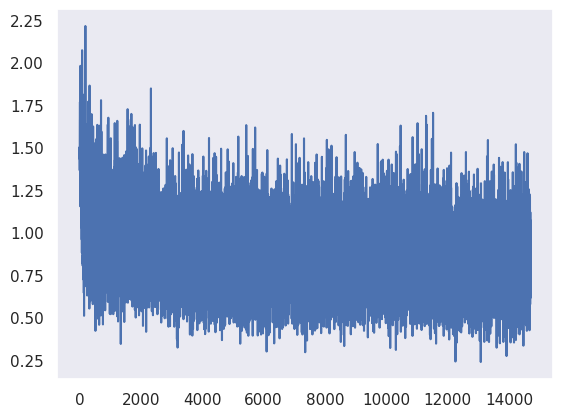

In [48]:
plt.plot(train_losses)

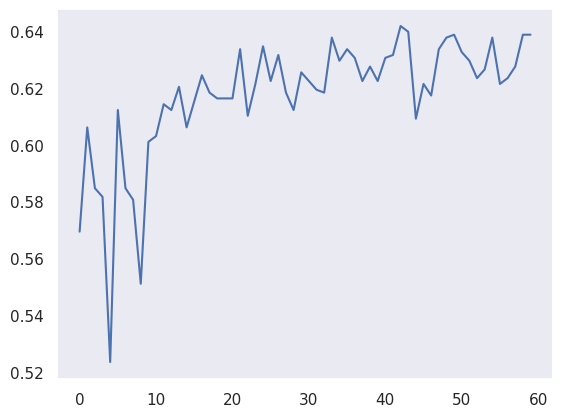

In [49]:
plt.plot(test_accuracy)

In [50]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

Correct: 626/976 (0.6414)
{'acc_detail': tensor([0.7549, 0.5945, 0.6969, 0.5119], device='cuda:0'),
 'acc_unweighted': tensor(0.6395, device='cuda:0'),
 'acc_weighted': tensor(0.6414, device='cuda:0'),
 'f1s_detail': tensor([0.7304, 0.5670, 0.7239, 0.5320], device='cuda:0'),
 'f1s_unweighted': tensor(0.6383, device='cuda:0'),
 'f1s_weighted': tensor(0.6412, device='cuda:0'),
 'precision_detail': tensor([0.7074, 0.5420, 0.7532, 0.5536], device='cuda:0'),
 'recall_detail': tensor([0.7549, 0.5945, 0.6969, 0.5119], device='cuda:0'),
 'rocauc': tensor(0.8674, device='cuda:0'),
 'rocauc_detail': tensor([0.9203, 0.8481, 0.9200, 0.7813], device='cuda:0'),
 'uar': tensor(0.6395, device='cuda:0'),
 'wap': tensor(0.6429, device='cuda:0')}


tensor([[191,  12,   0,  50],
        [  6, 129,  44,  38],
        [  3,  58, 177,  16],
        [ 70,  39,  14, 129]], device='cuda:0')

In [51]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M13(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

../models_cremad4/cremad_label4_m14sinc_fixed_best_43epoch.pt
Correct: 629/976 (0.6445)
{'acc_detail': tensor([0.7036, 0.6498, 0.7047, 0.5198], device='cuda:0'),
 'acc_unweighted': tensor(0.6445, device='cuda:0'),
 'acc_weighted': tensor(0.6445, device='cuda:0'),
 'f1s_detail': tensor([0.7325, 0.5709, 0.7218, 0.5504], device='cuda:0'),
 'f1s_unweighted': tensor(0.6439, device='cuda:0'),
 'f1s_weighted': tensor(0.6468, device='cuda:0'),
 'precision_detail': tensor([0.7639, 0.5090, 0.7397, 0.5848], device='cuda:0'),
 'recall_detail': tensor([0.7036, 0.6498, 0.7047, 0.5198], device='cuda:0'),
 'rocauc': tensor(0.8647, device='cuda:0'),
 'rocauc_detail': tensor([0.9194, 0.8417, 0.9172, 0.7806], device='cuda:0'),
 'uar': tensor(0.6445, device='cuda:0'),
 'wap': tensor(0.6547, device='cuda:0')}


tensor([[178,  17,   0,  58],
        [  4, 141,  46,  26],
        [  3,  63, 179,   9],
        [ 48,  56,  17, 131]], device='cuda:0')

In [52]:
checkpoint_path = f'../models_cremad4/cremad4_m14sinc_fixed_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [53]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40

optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.02, pct_start=0.3,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1+n_epoch+n_epoch2, n_epoch3+n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

  0%|                                                                   | 0.0032679738562091504/40 [00:00<1:24:14, 126.38s/it]

Train Epoch: 61 [0/3920 (0%)]	Loss: 0.532739
Mem before-during-after: 27426816 3971937280 30601216


  0%|▏                                                                     | 0.1339869281045752/40 [00:17<1:33:19, 140.45s/it]

Train Epoch: 61 [640/3920 (16%)]	Loss: 0.581125
Mem before-during-after: 30601216 3974860288 30601216


  1%|▍                                                                    | 0.26470588235294074/40 [00:33<1:32:49, 140.17s/it]

Train Epoch: 61 [1280/3920 (33%)]	Loss: 0.842422
Mem before-during-after: 30601216 3975741952 30726144


  1%|▋                                                                     | 0.3954248366013063/40 [00:50<1:33:01, 140.93s/it]

Train Epoch: 61 [1920/3920 (49%)]	Loss: 0.743942
Mem before-during-after: 30601216 3974797824 30601216


  1%|▉                                                                     | 0.5261437908496719/40 [01:06<1:32:23, 140.44s/it]

Train Epoch: 61 [2560/3920 (65%)]	Loss: 0.899286
Mem before-during-after: 30726144 3974735360 30601216


  2%|█▏                                                                    | 0.6568627450980374/40 [01:23<1:32:39, 141.31s/it]

Train Epoch: 61 [3200/3920 (82%)]	Loss: 0.919397
Mem before-during-after: 30925824 3974178304 30601216


  2%|█▍                                                                     | 0.787581699346403/40 [01:39<1:31:40, 140.27s/it]

Train Epoch: 61 [3840/3920 (98%)]	Loss: 0.641163
Mem before-during-after: 30601216 3975122432 30601216


  2%|█▊                                                                        | 0.999999999999997/40 [01:57<52:43, 81.13s/it]


Test Epoch: 61	Accuracy: 620/976 (63%)



  3%|█▊                                                                     | 1.0032679738562063/40 [01:58<1:01:48, 95.09s/it]

Train Epoch: 62 [0/3920 (0%)]	Loss: 0.394979
Mem before-during-after: 30600192 3975111168 30601216


  3%|█▉                                                                    | 1.1339869281045718/40 [02:14<1:30:42, 140.04s/it]

Train Epoch: 62 [640/3920 (16%)]	Loss: 0.736972
Mem before-during-after: 30726144 3977380352 30925824


  3%|██▏                                                                   | 1.2647058823529373/40 [02:31<1:30:24, 140.03s/it]

Train Epoch: 62 [1280/3920 (33%)]	Loss: 0.707165
Mem before-during-after: 30601216 3973916160 30601216


  3%|██▍                                                                    | 1.395424836601303/40 [02:47<1:30:38, 140.88s/it]

Train Epoch: 62 [1920/3920 (49%)]	Loss: 0.816737
Mem before-during-after: 30601216 3975122432 30601216


  4%|██▋                                                                   | 1.5261437908496684/40 [03:04<1:30:07, 140.56s/it]

Train Epoch: 62 [2560/3920 (65%)]	Loss: 0.996736
Mem before-during-after: 30601216 3975122432 30601216


  4%|██▉                                                                    | 1.656862745098034/40 [03:21<1:29:11, 139.57s/it]

Train Epoch: 62 [3200/3920 (82%)]	Loss: 0.771547
Mem before-during-after: 30601216 3944874496 30601216


  4%|███▏                                                                  | 1.7875816993463995/40 [03:37<1:29:11, 140.05s/it]

Train Epoch: 62 [3840/3920 (98%)]	Loss: 0.572731
Mem before-during-after: 30601216 3975122432 30601216


  5%|███▋                                                                     | 1.9999999999999936/40 [03:55<50:38, 79.97s/it]


Test Epoch: 62	Accuracy: 625/976 (64%)



  5%|███▋                                                                      | 2.003267973856203/40 [03:55<59:35, 94.11s/it]

Train Epoch: 63 [0/3920 (0%)]	Loss: 0.750252
Mem before-during-after: 30600192 3975111168 30601216


  5%|███▋                                                                  | 2.1339869281045685/40 [04:12<1:28:12, 139.77s/it]

Train Epoch: 63 [640/3920 (16%)]	Loss: 0.823431
Mem before-during-after: 30601216 3974797824 30601216


  6%|████                                                                   | 2.264705882352934/40 [04:29<1:29:24, 142.15s/it]

Train Epoch: 63 [1280/3920 (33%)]	Loss: 0.639137
Mem before-during-after: 30601216 3975596544 30601216


  6%|████▏                                                                 | 2.3954248366012996/40 [04:45<1:27:33, 139.70s/it]

Train Epoch: 63 [1920/3920 (49%)]	Loss: 0.669293
Mem before-during-after: 30601216 3975009792 30601216


  6%|████▍                                                                  | 2.526143790849665/40 [05:02<1:27:05, 139.44s/it]

Train Epoch: 63 [2560/3920 (65%)]	Loss: 0.503941
Mem before-during-after: 30601216 3975009792 30601216


  7%|████▋                                                                 | 2.6568627450980307/40 [05:18<1:27:09, 140.03s/it]

Train Epoch: 63 [3200/3920 (82%)]	Loss: 0.627868
Mem before-during-after: 30601216 3975596544 30925824


  7%|████▉                                                                  | 2.787581699346396/40 [05:35<1:29:52, 144.92s/it]

Train Epoch: 63 [3840/3920 (98%)]	Loss: 0.870055
Mem before-during-after: 30601216 3975009792 30601216


  7%|█████▍                                                                   | 2.9999999999999902/40 [05:53<50:57, 82.62s/it]


Test Epoch: 63	Accuracy: 598/976 (61%)



  8%|█████▍                                                                   | 3.0032679738561994/40 [05:53<59:23, 96.33s/it]

Train Epoch: 64 [0/3920 (0%)]	Loss: 0.897454
Mem before-during-after: 30600192 3975110656 30601216


  8%|█████▌                                                                 | 3.133986928104565/40 [06:10<1:30:33, 147.39s/it]

Train Epoch: 64 [640/3920 (16%)]	Loss: 0.840825
Mem before-during-after: 30601216 3975941632 30925824


  8%|█████▋                                                                | 3.2647058823529305/40 [06:27<1:26:20, 141.01s/it]

Train Epoch: 64 [1280/3920 (33%)]	Loss: 1.040422
Mem before-during-after: 30601216 3973916160 30601216


  8%|██████                                                                 | 3.395424836601296/40 [06:44<1:26:10, 141.24s/it]

Train Epoch: 64 [1920/3920 (49%)]	Loss: 0.626963
Mem before-during-after: 30601216 3975524864 30601216


  9%|██████▏                                                               | 3.5261437908496616/40 [07:01<1:25:08, 140.07s/it]

Train Epoch: 64 [2560/3920 (65%)]	Loss: 0.538275
Mem before-during-after: 30601216 3975524864 30601216


  9%|██████▍                                                                | 3.656862745098027/40 [07:17<1:25:17, 140.81s/it]

Train Epoch: 64 [3200/3920 (82%)]	Loss: 1.119143
Mem before-during-after: 30601216 3975587328 30601216


  9%|██████▋                                                               | 3.7875816993463927/40 [07:34<1:25:46, 142.13s/it]

Train Epoch: 64 [3840/3920 (98%)]	Loss: 0.986322
Mem before-during-after: 30601216 3976865280 30601216


 10%|███████▎                                                                 | 3.9999999999999867/40 [07:52<49:08, 81.91s/it]


Test Epoch: 64	Accuracy: 618/976 (63%)



 10%|███████▍                                                                  | 4.003267973856196/40 [07:52<57:37, 96.05s/it]

Train Epoch: 65 [0/3920 (0%)]	Loss: 0.688637
Mem before-during-after: 30600192 3975110656 30601216


 10%|███████▎                                                               | 4.133986928104561/40 [08:09<1:24:50, 141.94s/it]

Train Epoch: 65 [640/3920 (16%)]	Loss: 0.957048
Mem before-during-after: 30601216 3975122432 30601216


 11%|███████▌                                                               | 4.264705882352927/40 [08:26<1:24:22, 141.67s/it]

Train Epoch: 65 [1280/3920 (33%)]	Loss: 0.759203
Mem before-during-after: 30601216 3975184896 30726144


 11%|███████▋                                                              | 4.3954248366012925/40 [08:42<1:25:22, 143.87s/it]

Train Epoch: 65 [1920/3920 (49%)]	Loss: 1.249129
Mem before-during-after: 30601216 3974797824 30601216


 11%|████████                                                               | 4.526143790849658/40 [08:59<1:23:49, 141.79s/it]

Train Epoch: 65 [2560/3920 (65%)]	Loss: 1.114983
Mem before-during-after: 30601216 3975184896 30726144


 12%|████████▎                                                              | 4.656862745098024/40 [09:16<1:23:17, 141.41s/it]

Train Epoch: 65 [3200/3920 (82%)]	Loss: 0.606758
Mem before-during-after: 30601216 3975122432 30601216


 12%|████████▍                                                              | 4.787581699346389/40 [09:33<1:23:38, 142.53s/it]

Train Epoch: 65 [3840/3920 (98%)]	Loss: 0.844909
Mem before-during-after: 30726144 3974735360 30601216


 12%|█████████▏                                                                | 4.999999999999983/40 [09:51<47:36, 81.61s/it]


Test Epoch: 65	Accuracy: 614/976 (63%)



 13%|█████████▎                                                                | 5.003267973856192/40 [09:51<56:04, 96.15s/it]

Train Epoch: 66 [0/3920 (0%)]	Loss: 1.132572
Mem before-during-after: 30600192 3975110656 30601216


 13%|████████▉                                                              | 5.052287581699329/40 [09:57<1:15:20, 129.34s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f379ad08be0>>
Traceback (most recent call last):
  File "/home/bunny/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
 13%|████████▊                                                             | 5.0555555555555385/40 [09:58<1:15:16, 129.26s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f379ad08be0>>
Traceback (most recent call last):
  File "/home/bunny/anaconda3/envs/audio/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ig

KeyboardInterrupt: 

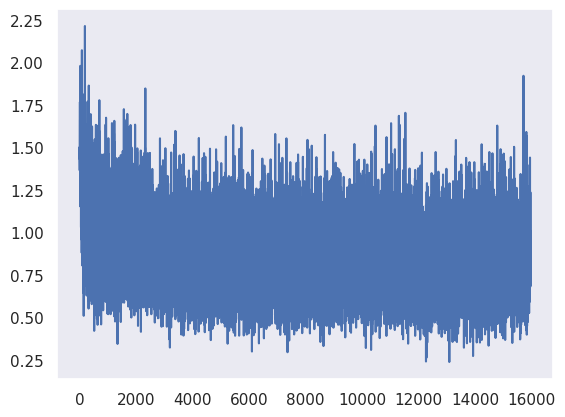

In [54]:
plt.plot(train_losses)

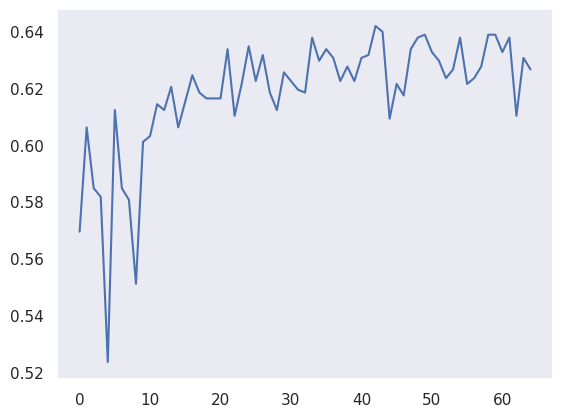

In [55]:
plt.plot(test_accuracy)

In [56]:
epoch = epoch-1
checkpoint_path = f'../models_cremad4/cremad4_m14sinc_fixed_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)

In [ ]:
model

In [43]:
from IConNet.visualizer import display_module

/home/linh/projects/IConNet/IConNet/conv/longconv.py:194: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert filters.shape[1] == self.in_channels
/home/linh/projects/IConNet/IConNet/conv/pad.py:74: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if residual <= 0:
/home/linh/projects/IConNet/IConNet/conv/longconv.py:86: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not ge

aten::mean %x : Float(1, 229, strides=[229, 1], requires_grad=1, device=cuda:0) = aten::mean(%1300, %1149, %1150, %1151) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



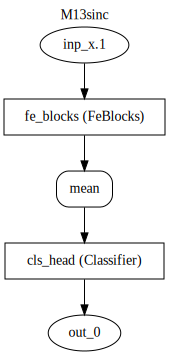

In [44]:
input_shape = (1,1,16000)
best_model.to(device)
input = torch.rand(input_shape).to(device)
display_module(
    model, input, 
    classes_to_visit={})

/home/linh/projects/IConNet/IConNet/conv/longconv.py:194: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert filters.shape[1] == self.in_channels
/home/linh/projects/IConNet/IConNet/conv/pad.py:74: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if residual <= 0:
/home/linh/projects/IConNet/IConNet/conv/longconv.py:86: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not ge

aten::mean %x : Float(1, 229, strides=[229, 1], requires_grad=1, device=cuda:0) = aten::mean(%1300, %1149, %1150, %1151) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



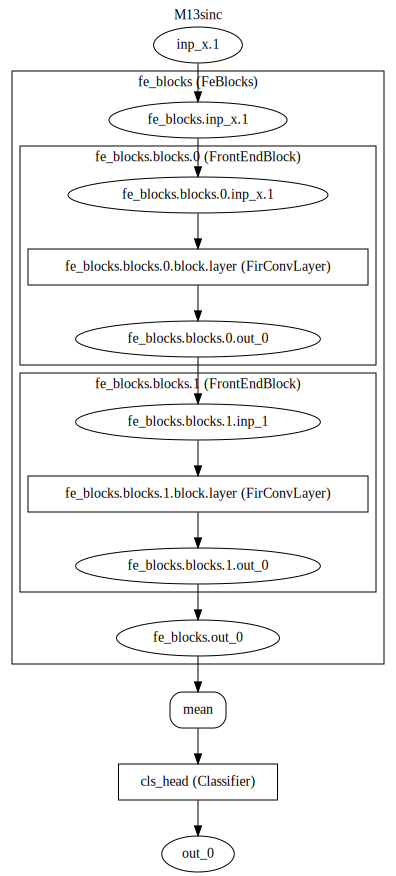

In [45]:
display_module(
    best_model, input, 
    classes_to_visit={"FeBlocks", "FrontEndBlock"})

/home/linh/projects/IConNet/IConNet/conv/longconv.py:194: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert filters.shape[1] == self.in_channels
/home/linh/projects/IConNet/IConNet/conv/pad.py:74: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if residual <= 0:
/home/linh/projects/IConNet/IConNet/conv/longconv.py:86: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not ge

aten::mean %x : Float(1, 229, strides=[229, 1], requires_grad=1, device=cuda:0) = aten::mean(%1300, %1149, %1150, %1151) # /opt/anaconda3/envs/audio/lib/python3.9/site-packages/einops/_backends.py:247:0



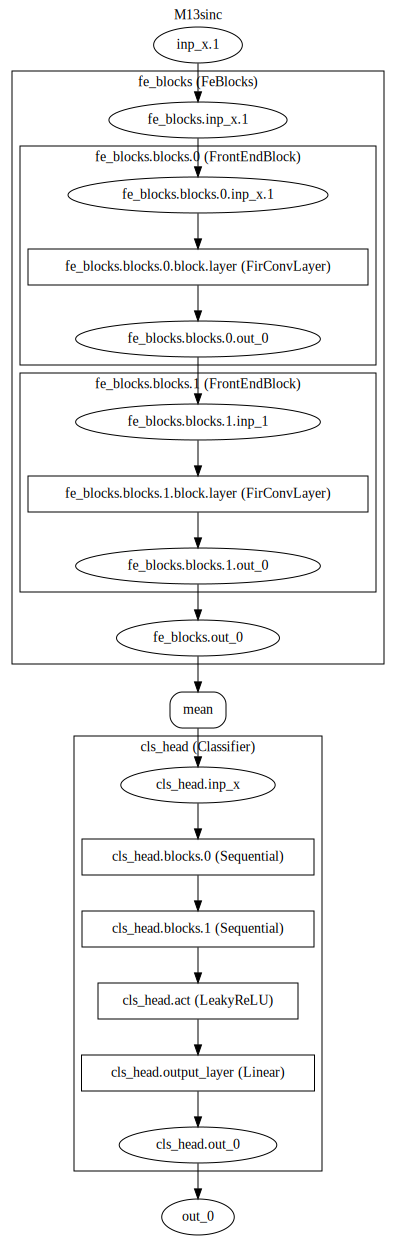

In [46]:
display_module(
    best_model, input, 
    classes_to_visit={"FeBlocks", "FrontEndBlock", "Classifier"})

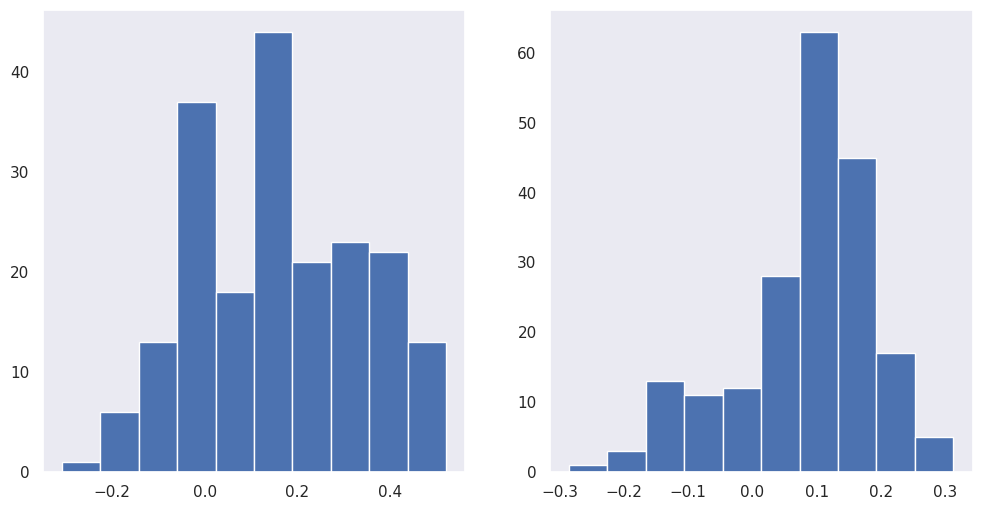

In [57]:
from IConNet.visualizer import visualize_model

layer = best_model.fe_blocks.blocks[0].block.layer

filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = windows, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_bands()

Frequency domain: Filters' shapes vary by frequency bins


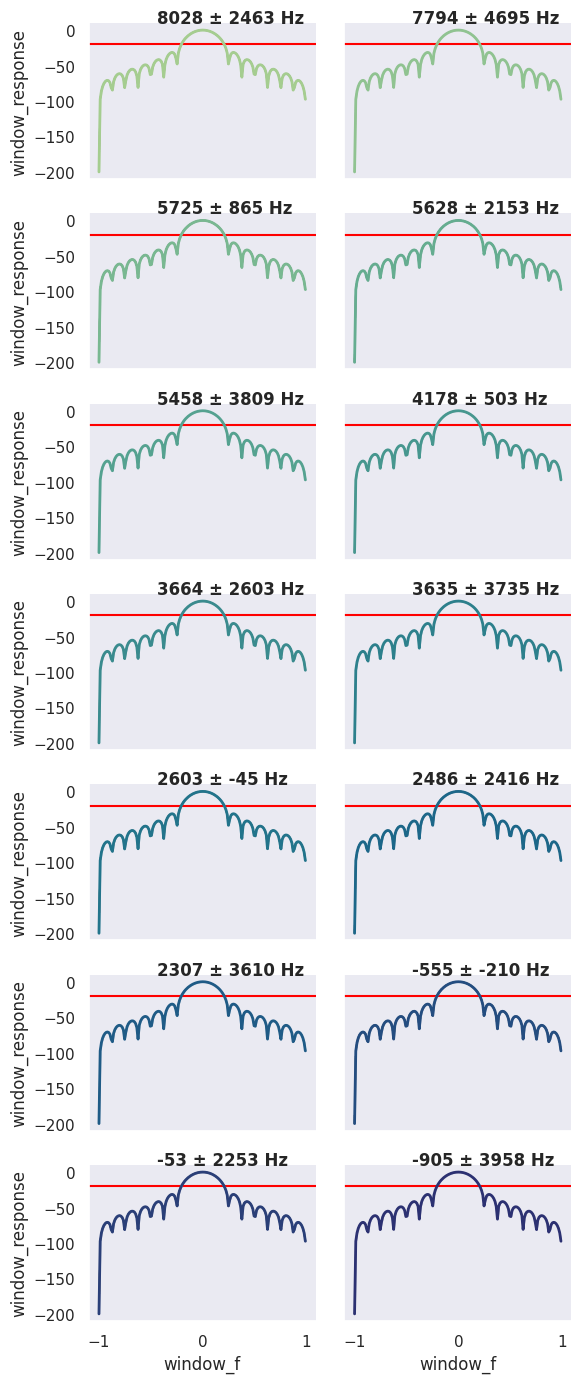

In [58]:
filtviz.visualize_filters(filter_domain='freq')

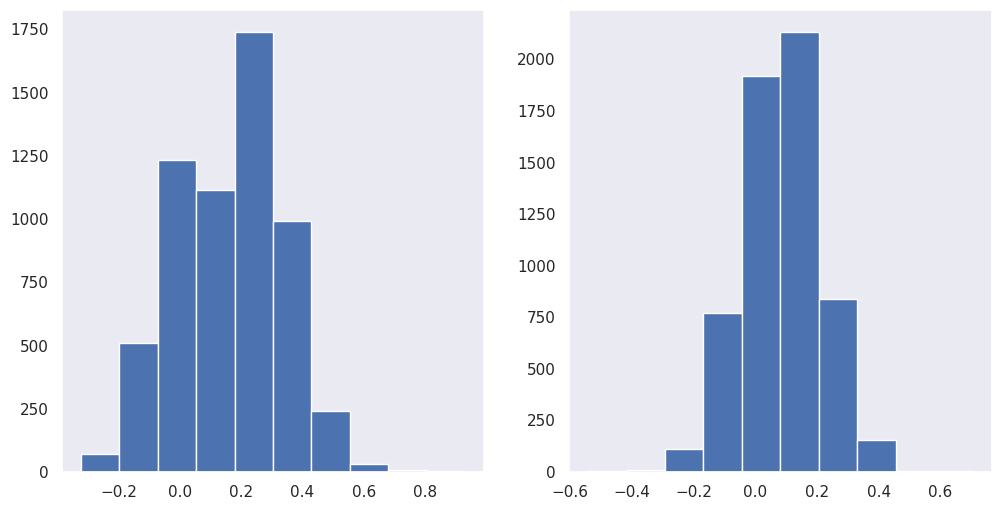

In [59]:
layer2 = best_model.fe_blocks.blocks[1].block.layer

filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = None, 
    window_length = 64,
    sample_rate = sr
)
filtviz2.visualize_bands()

In [52]:
del model
del best_model
gc.collect()

19668